In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [2]:
df = pd.read_csv("data_combined.csv") # 학습용 데이터
df.head()

,Unnamed: 0,성별,나이,발생일,위해원인,위해증상대분류,위해증상소분류,위해부위1,위해부위2,발생장소1,발생장소2,품목
0,0,남자,59.0,20200301.0,부패·변질,피부 및 피하조직 손상,가려움,기타 위해부위>전신 손상,다발손상여부>6부위 이상,상세불명의 주택,주방,쌀
1,1,여자,39.0,20200630.0,부패·변질,신체내부 장기손상,소화기계통 장기손상 및 통증,"신체내부>신체내부-소화계통(식도,위장,대장 등)",다발손상여부>해당없음,상세불명의 주택,주방,쌀
2,2,여자,2.0,20200619.0,이물질(기타),기타 손상,체내 위험 이물질,머리 및 얼굴>귀 및 고막,다발손상여부>해당없음,아파트,주방,쌀
3,3,여자,49.0,20201201.0,이물질(벌레),해당없음,해당없음,해당없음>해당없음,다발손상여부>해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",쌀
4,4,여자,52.0,20200311.0,식품 섭취에 의한 위험 및 위해,피부 및 피하조직 손상,두드러기,"팔 및 손>팔(아래부분, 팔꿈치 및 손목 제외)",다발손상여부>해당없음,아파트,거실,쌀


In [3]:
df.shape

(301877, 12)

# 전처리) 불필요 컬럼 삭제/ 위해부위1,2 / 발생일 / 나이 / 성별

## 불필요 컬럼(Unnamed: 0) 삭제(공통)

In [4]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

## 위해부위 1,2

In [5]:
# '>' 이후의 문자열을 추출하는 함수 정의
def extract_text_after_symbol(text):
    parts = text.split('>')  # '>'을 기준으로 문자열 분할
    if len(parts) > 1:
        return parts[1]  # '>' 이후의 문자열 반환
    else:
        return text  # '>'가 없으면 그대로 반환

# '위해부위1' 열을 처리하여 새로운 칼럼에 할당
df['Processed_위해부위1'] = df['위해부위1'].apply(extract_text_after_symbol)
df['Processed_위해부위2'] = df['위해부위2'].apply(extract_text_after_symbol)

In [6]:
df['위해부위1'] = df['Processed_위해부위1']
df['위해부위2'] = df['Processed_위해부위2']
df.drop(columns=['Processed_위해부위1'], inplace=True)
df.drop(columns=['Processed_위해부위2'], inplace=True)

In [7]:
df['위해부위2'].value_counts()

위해부위2
해당없음       262845
2부위~3부위     22253
6부위 이상      14420
4부위~5부위      2359
Name: count, dtype: int64

## 발생일 -> 이상값 8글자로 변경, 2020~2023 아니면 행 삭제, 결측값 행 삭제

In [8]:
df['발생일'] = df['발생일'].fillna(0).astype(int)   #결측값 0으로 대체

In [9]:
df['발생일'].value_counts()

발생일
0           1976
20200901    1823
20200701    1766
20200801    1471
20200301    1434
20201201    1371
20201101    1354
20210501    1347
20210601    1346
20220601    1308
20201001    1272
20211001    1251
20210801    1240
20220101    1238
20230801    1224
20210401    1184
20210701    1137
20200601    1126
20230301    1120
20230601    1098
20230701    1085
20210901    1084
20220701    1064
20221201    1028
20231101    1021
20200401    1015
20220801     989
20231001     985
20211101     967
20220901     947
20220501     929
20230101     926
20230401     924
20220301     920
20200201     912
20230501     860
20221001     840
20200501     839
20230901     825
20220201     822
20210101     810
20220401     807
20211201     764
20230201     741
20210301     706
20221101     635
20210201     546
20200101     421
20210917     402
20210910     398
20231201     383
20210614     375
20210918     368
20210611     355
20210913     354
20210531     343
20210906     341
20210731     336
20210930  

In [10]:
# 8글자가 아닌 '발생일' 값을 가지는 행들을 뽑아내는 함수
def filter_invalid_length_dates(date):
    date_str = str(date)
    if date_str == 'None':
        return None  # 빈 문자열인 경우 None 반환
    if len(date_str) != 8:
        return "others"
    else:
        return date

df['발생일1'] = df['발생일'].apply(filter_invalid_length_dates)

df[df['발생일1'] == 'others']['발생일'].value_counts()

발생일
0          1976
2100601       2
2100201       1
2101209       1
2100701       1
2210701       1
2101227       1
2211231       1
2211216       1
2020201       1
2211101       1
2220101       1
2211225       1
200101        1
Name: count, dtype: int64

In [11]:
def process_values(value):
    value_str = str(value)
    if len(value_str) == 7:
        return '20'+value_str[0:2]+value_str[3:]
    elif len(value_str) == 6:
        return '20'+value_str[0:]
    elif value_str == '0':
        return None
    else:
        return value

df['발생일'] = df['발생일'].apply(process_values)
df[df['발생일1'] == 'others']['발생일'].value_counts()

발생일
20210601    2
20210201    1
20211209    1
20210701    1
20220701    1
20211227    1
20221231    1
20221216    1
20200201    1
20221101    1
20220101    1
20221225    1
20200101    1
Name: count, dtype: int64

In [12]:
# NaN 값 제거
df = df.dropna(subset=['발생일'],axis=0)

In [13]:
def filter_valid_years(value):
    value_str = str(value)
    year = value_str[:4]
    if year in ['2020', '2021', '2022', '2023']:
        return value
    else:
        return 0

df['발생일1'] = df['발생일'].apply(filter_valid_years)
df[df['발생일1'] == 0]['발생일'].value_counts()
# df['발생일1'].value_counts(dropna=False)

발생일
20191229    184
20191221    172
20191228    164
20191231    150
20191230    143
20191225    142
20191201    141
20191222    136
20191226    123
20191224    122
20191220    114
20191223    113
20191227    112
20191219    108
20191217    100
20191218     99
20191215     92
20191216     90
20191214     55
20191101     45
20191210     33
20191213     32
20191212     29
20191207     26
20191001     26
20191208     23
20191205     22
20190101     22
20191202     20
20191209     18
20191130     18
20191206     18
20191129     16
20191211     15
20191203     15
20190901     14
20190801     13
20191204     12
20191124     12
20191128     11
20191123     11
20191127     10
20191125     10
20191025      9
20191013      9
20180101      8
20191019      7
20190301      7
20190501      7
20191112      7
20190902      7
20191121      7
20191120      7
20190701      7
20191018      7
20191122      7
20190601      7
20191117      7
20191015      6
20191108      6
20191109      6
20191010      6
2019

In [14]:
df['발생일'] = df['발생일'].apply(filter_valid_years)
df.loc[df['발생일'] == 0, '발생일'] = None

df = df.dropna(subset=['발생일'],axis=0)
df.drop(["발생일1"], axis=1, inplace=True)

In [15]:
df['발생일'].value_counts(dropna=False)
df.head()

,성별,나이,발생일,위해원인,위해증상대분류,위해증상소분류,위해부위1,위해부위2,발생장소1,발생장소2,품목
0,남자,59.0,20200301,부패·변질,피부 및 피하조직 손상,가려움,전신 손상,6부위 이상,상세불명의 주택,주방,쌀
1,여자,39.0,20200630,부패·변질,신체내부 장기손상,소화기계통 장기손상 및 통증,"신체내부-소화계통(식도,위장,대장 등)",해당없음,상세불명의 주택,주방,쌀
2,여자,2.0,20200619,이물질(기타),기타 손상,체내 위험 이물질,귀 및 고막,해당없음,아파트,주방,쌀
3,여자,49.0,20201201,이물질(벌레),해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",쌀
4,여자,52.0,20200311,식품 섭취에 의한 위험 및 위해,피부 및 피하조직 손상,두드러기,"팔(아래부분, 팔꿈치 및 손목 제외)",해당없음,아파트,거실,쌀


In [16]:
df.shape

(296578, 11)

## 나이 -> 결측값 처리(중위값으로 대체), 이산화(5살 구간)

In [17]:
df['나이'].value_counts(dropna=False)

나이
NaN      31940
49.0     20949
59.0     17534
39.0     17243
1.0      12076
2.0       9492
3.0       8830
0.0       8580
4.0       7258
5.0       5806
29.0      5598
6.0       4451
7.0       3955
79.0      3450
8.0       3125
63.0      2903
64.0      2888
9.0       2844
23.0      2714
66.0      2704
62.0      2674
65.0      2582
26.0      2558
25.0      2540
10.0      2538
24.0      2510
27.0      2502
11.0      2388
28.0      2344
61.0      2336
22.0      2316
67.0      2286
20.0      2275
60.0      2270
68.0      2206
12.0      2137
30.0      2106
21.0      2070
19.0      2026
40.0      1946
13.0      1934
31.0      1915
51.0      1911
14.0      1819
69.0      1798
58.0      1796
54.0      1791
57.0      1751
55.0      1750
32.0      1749
52.0      1742
35.0      1741
50.0      1735
53.0      1734
38.0      1664
41.0      1642
33.0      1638
56.0      1622
42.0      1592
34.0      1580
48.0      1575
37.0      1564
70.0      1527
44.0      1501
18.0      1487
47.0      1458
71.0   

/Users/parkjayoung/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Age Distribution - Histogram')

/Users/parkjayoung/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  func(*args, **kwargs)
/Users/parkjayoung/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/Users/parkjayoung/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/parkjayoung/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


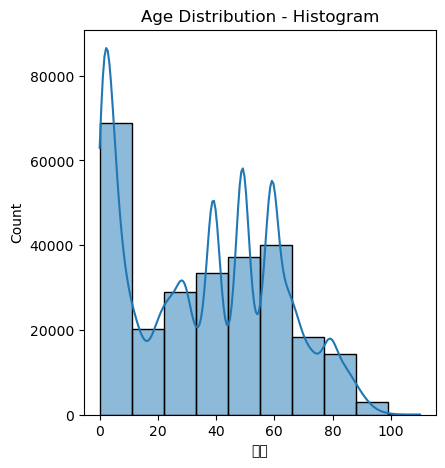

In [18]:
# 히스토그램 그리기
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['나이'], bins=10, kde=True)
plt.title('Age Distribution - Histogram')

In [19]:
df['나이'].describe()

count    264638.000000
mean         36.297546
std          25.695763
min           0.000000
25%           9.000000
50%          39.000000
75%          59.000000
max         110.000000
Name: 나이, dtype: float64

In [20]:
# 중위값 계산 (결측값을 제외한)
median_value = int(df['나이'].median())

# 결측값을 중위값으로 대체
df['나이'] = df['나이'].fillna(median_value).astype(int)

In [21]:
df['나이'].value_counts(dropna=False)

나이
39     49183
49     20949
59     17534
1      12076
2       9492
3       8830
0       8580
4       7258
5       5806
29      5598
6       4451
7       3955
79      3450
8       3125
63      2903
64      2888
9       2844
23      2714
66      2704
62      2674
65      2582
26      2558
25      2540
10      2538
24      2510
27      2502
11      2388
28      2344
61      2336
22      2316
67      2286
20      2275
60      2270
68      2206
12      2137
30      2106
21      2070
19      2026
40      1946
13      1934
31      1915
51      1911
14      1819
69      1798
58      1796
54      1791
57      1751
55      1750
32      1749
52      1742
35      1741
50      1735
53      1734
38      1664
41      1642
33      1638
56      1622
42      1592
34      1580
48      1575
37      1564
70      1527
44      1501
18      1487
47      1458
71      1454
36      1452
46      1450
73      1447
43      1440
45      1414
72      1405
15      1354
17      1324
81      1302
16      1302
80      1

In [22]:
# 나이를 5살 간격으로 이산화하여 새로운 범주형 변수 생성
def categorize_age(age):
    age_group = (age // 5) * 5
    return f'{age_group}-{age_group + 4}'

df['범주형 나이'] = df['나이'].apply(categorize_age)

In [23]:
df['범주형 나이'].value_counts()

범주형 나이
35-39      55604
0-4        46236
45-49      26846
55-59      24453
5-9        20181
25-29      15542
60-64      13071
20-24      11885
65-69      11576
10-14      10816
30-34       8988
50-54       8913
40-44       8121
75-79       8051
15-19       7493
70-74       7110
80-84       6012
85-89       3879
90-94       1462
95-99        299
100-104       37
105-109        2
110-114        1
Name: count, dtype: int64

In [24]:
df.head(20)

,성별,나이,발생일,위해원인,위해증상대분류,위해증상소분류,위해부위1,위해부위2,발생장소1,발생장소2,품목,범주형 나이
0,남자,59,20200301,부패·변질,피부 및 피하조직 손상,가려움,전신 손상,6부위 이상,상세불명의 주택,주방,쌀,55-59
1,여자,39,20200630,부패·변질,신체내부 장기손상,소화기계통 장기손상 및 통증,"신체내부-소화계통(식도,위장,대장 등)",해당없음,상세불명의 주택,주방,쌀,35-39
2,여자,2,20200619,이물질(기타),기타 손상,체내 위험 이물질,귀 및 고막,해당없음,아파트,주방,쌀,0-4
3,여자,49,20201201,이물질(벌레),해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",쌀,45-49
4,여자,52,20200311,식품 섭취에 의한 위험 및 위해,피부 및 피하조직 손상,두드러기,"팔(아래부분, 팔꿈치 및 손목 제외)",해당없음,아파트,거실,쌀,50-54
5,여자,3,20200520,이물질(기타),기타 손상,체내 위험 이물질,귀 및 고막,해당없음,아파트,주방,쌀,0-4
6,여자,39,20200329,이물질(기타),해당없음,해당없음,해당없음,해당없음,상세불명의 주택,주방,쌀,35-39
7,여자,59,20201101,이물질(돌),"근육, 뼈 및 인대 손상",파쇄(부서짐),치아,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",쌀,55-59
8,남자,49,20201015,부패·변질,해당없음,해당없음,해당없음,해당없음,상세불명의 주택,주방,쌀,45-49
9,여자,39,20201101,식품 섭취에 의한 위험 및 위해,해당없음,해당없음,해당없음,해당없음,상세불명의 주택,"상세불명의 장소, 부대·부속시설",쌀,35-39


## 성별 -> '미상', '해당없음' == '미상' 으로 변경

In [25]:
df["성별"].isna().sum()

0

In [26]:
df["성별"].isnull().sum()

0

In [27]:
df["성별"].value_counts(dropna=False)

성별
남자      145624
여자      140795
미상        6145
해당없음      4014
Name: count, dtype: int64

In [28]:
def filter_valid_gender(value):
    if value in ['미상', '해당없음']:
        return '미상'
    else:
        return value

df['성별__'] = df['성별'].apply(filter_valid_gender)
df[df['성별__'] == '미상']['성별'].value_counts()
df['성별__'].value_counts()

성별__
남자    145624
여자    140795
미상     10159
Name: count, dtype: int64

In [29]:
df['성별'] = df['성별'].apply(filter_valid_gender)

df.drop(["성별__"], axis=1, inplace=True)

# 그 외 값들 : 전처리x (결측값 확인)

## 위해원인 - 결측값 없음

In [30]:
df["위해원인"].isna().sum()

0

In [31]:
df["위해원인"].isnull().sum()

0

In [32]:
df["위해원인"].value_counts(dropna=False)

위해원인
미끄러짐·넘어짐             60559
식품 섭취에 의한 위험 및 위해    44234
기타 불량 및 고장           42398
추락                   25183
기타 의료시술 및 약물         15780
예리함·마감처리 불량          10379
파열·파손·꺾여짐            10304
부딪힘                   9216
기타 위험 및 위해내용          8632
기능고장                  8088
눌림·끼임                 7544
이물질(기타)               7445
기타 물리적 충격             4836
연료·액체 누수 등            4228
고온물질                  4154
피부접촉에 의한 위험 및 위해      4082
약물 부작용                3722
이물질(플라스틱)             3190
부패·변질                 2504
기타 화학물질               2103
이물질(금속)               2041
기타 전기관련               1792
부품탈락                  1640
이물질(액체류)              1609
화재                    1597
과열                    1427
조작·사용성 불량             1272
폭발                    1151
발화·불꽃                  940
기타 화재/발연/과열/가스 관련      816
이물질(벌레)                636
이물질(가스 및 기체류)          519
이물질(비닐)                433
가스누설 및 가스폭발            349
약물 오·남용                303
누전·전파 등의 장애            239
발연                     

## 위해증상대분류 - 결측값 없음

In [33]:
df["위해증상대분류"].isna().sum()

0

In [34]:
df["위해증상대분류"].isnull().sum()

0

In [35]:
df["위해증상대분류"].value_counts(dropna=False)

위해증상대분류
해당없음             93788
피부 및 피하조직 손상     80513
신체내부 장기손상        32875
뇌진탕 및 타박상        30717
근육, 뼈 및 인대 손상    27099
기타 손상            24874
화상                5831
전신손상               881
Name: count, dtype: int64

## 위해증상소분류 - 결측값 없음

In [36]:
df["위해증상소분류"].isna().sum()

0

In [37]:
df["위해증상소분류"].isnull().sum()

0

In [38]:
df["위해증상소분류"].value_counts(dropna=False)

위해증상소분류
해당없음                  93788
열상(찢어짐)               45271
타박상                   23530
소화기계통 장기손상 및 통증       23156
골절                    22705
체내 위험 이물질             10151
뇌진탕                    7187
찰과상                    6492
두드러기                   6338
심혈관계통 손상 및 통증          5664
피부염 또는 피부발진            5146
부종 또는 피부감각장애           4436
구토                     3883
결막염 또는 안구손상            3479
화상-열에 의한               3304
출혈 및 혈종                3163
두통                     2748
어지러움, 이명, 메스꺼움         2307
오한, 발열                 2246
절상(베임)                 2112
기타 피부 및 피하조직 손상        2062
염좌                     1967
화상-뜨거운 액체나 증기로 인한      1952
호흡기계통 장기손상 및 통증        1897
설사                     1830
탈구                     1519
신경계통 손상 및 통증           1171
기타 장기손상 및 통증            987
알레르기                    894
가려움                     814
위해증상 확인불가               795
자상(찔림)                  685
파쇄(부서짐)                 643
박리(벗겨짐)                 377
중독(약물, 가스, 화학물질 등)      372
식중독(부패·변질 음식

## 발생장소1 - 결측값 없음

In [39]:
df["발생장소1"].isna().sum()

0

In [40]:
df["발생장소1"].isnull().sum()

0

In [41]:
df["발생장소1"].value_counts(dropna=False)

발생장소1
아파트                    81205
상세불명의 장소               60286
상세불명의 주택               54081
다세대주택                  14173
카페 및 음식점               13677
상세불명의 도로 및 인도          12407
단독주택                    9210
일반도로                    7036
상세불명의 의료서비스시설           6747
개인병원                    3637
종합병원                    3507
연립주택                    3104
자전거도로                   2908
공원                      1286
초등학교                    1140
스키장                     1135
어린이집(놀이방)               1097
상세불명의 여가, 문화 및 놀이시설     1068
목욕탕                      989
키즈카페(실내놀이터)              787
지하철/지하철역                 715
인도                       697
상세불명의 상업시설               654
스케이트장                    647
보건소                      613
편의점                      558
중학교                      527
이미용실                     520
수영장                      491
대형/복합쇼핑몰                 462
유치원                      440
요양원                      426
호텔                       368
상세불명의 스포츠/레저시설           362
고속도로/자동차

## 발생장소2 - 결측값 없음

In [42]:
df["발생장소2"].isna().sum()

0

In [43]:
df["발생장소2"].isnull().sum()

0

In [44]:
df["발생장소2"].value_counts(dropna=False)

발생장소2
상세불명의 장소, 부대·부속시설     112172
주방                     42912
시설목적공간                 37613
침실/방                   35972
거실                     28531
화장실/욕실                 18851
놀이터                     6253
주차장                     2538
현관                      2283
에스컬레이터/무빙워크             1815
베란다(발코니)                1540
기타 장소, 부대·부속시설          1250
교실                      1100
정원/마당                   1069
운동장                      948
엘리베이터                    515
복도                       315
체육시설                     272
풀(POOL)                  170
옥상                       126
계단                        96
강당                        88
급식시설                      86
휴게시설                      38
탕비실                       25
Name: count, dtype: int64

## 품목 - 결측값 없음

In [45]:
df["품목"].isna().sum()

0

In [46]:
df["품목"].isnull().sum()

0

In [47]:
df["품목"].value_counts(dropna=False)

품목
주사액                                15560
석재 또는 타일바닥재                        13736
침대                                  9730
일반자전거                               7664
목재마루재                               7256
비닐바닥재                               7109
기타 영양보충제품                           4415
가정용 정수기                             4409
전동휠                                 4154
가정용 냉장고                             3903
킥보드                                 3759
국내 승용차-중형                           3615
어린이자전거                              3584
소파                                  3381
기타 승용물                              3204
휴대폰                                 3092
텔레비전                                2915
목재문                                 2870
기타 완구                               2758
국내 승용차-대형                           2591
가정용 에어컨(고정식)                        2532
회                                   2512
수산물                                 2271
가정용 김치냉장고                           2256
전기마사지기       

# 파생변수 생성


## 파생변수 "연령대 분류" 생성

In [48]:
# 나이를 범주로 변환하는 함수 정의
def categorize_age(age):    
    if age <= 5:
        return '유아'
    elif age <= 12:
        return '어린이'
    elif age <= 18:
        return '청소년'
    elif age <= 34:
        return '청년'
    elif age <= 64:
        return '성인'
    elif age == 999:
        return '알 수 없음'
    else:
        return '노인'
    
# '나이' 열을 범주로 변환
df['연령대분류'] = df['나이'].apply(categorize_age)

df['연령대분류'].value_counts(dropna=False)

연령대분류
성인     137008
유아      52042
청년      38441
노인      38429
어린이     21438
청소년      9220
Name: count, dtype: int64

In [49]:
df.drop(columns=['나이'], inplace=True)

In [50]:
df.head()

,성별,발생일,위해원인,위해증상대분류,위해증상소분류,위해부위1,위해부위2,발생장소1,발생장소2,품목,범주형 나이,연령대분류
0,남자,20200301,부패·변질,피부 및 피하조직 손상,가려움,전신 손상,6부위 이상,상세불명의 주택,주방,쌀,55-59,성인
1,여자,20200630,부패·변질,신체내부 장기손상,소화기계통 장기손상 및 통증,"신체내부-소화계통(식도,위장,대장 등)",해당없음,상세불명의 주택,주방,쌀,35-39,성인
2,여자,20200619,이물질(기타),기타 손상,체내 위험 이물질,귀 및 고막,해당없음,아파트,주방,쌀,0-4,유아
3,여자,20201201,이물질(벌레),해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",쌀,45-49,성인
4,여자,20200311,식품 섭취에 의한 위험 및 위해,피부 및 피하조직 손상,두드러기,"팔(아래부분, 팔꿈치 및 손목 제외)",해당없음,아파트,거실,쌀,50-54,성인


## 파생변수 "품목대분류" 생성


In [51]:
df['품목'].nunique()

1981

In [52]:
category_mapping = {
    '건축/인테리어 자재 및 작업공구': ['석재타일 또는 판석', '기타 타일 및 판석', '지붕슬레이트', '기타 지붕재료 및 액세서리', '홈통', '기타 옥외 배수구 및 배수구 액세서리', '셔터', '차양', '캐노피', '금속재 울타리', '기타 외벽용 제품 및 울타리', '페인트', '돌벽, 건식벽체', '석고보드', '발포 폴리스티렌 단열제', '기타 내벽 마무리 및 표면재료', '목재마루재', '석재 또는 타일바닥재', '비닐바닥재', '옥외바닥재', '마루 장선,마루 들보', '합판', '기타 바닥재', '유리문', '철망문', '목재문', '금속문', '문틀', '회전문', '자동문', '스크린도어', '대문', '기타 문', '유리창', '기타 창문', '강화유리', '판유리', '창턱', '새시', '기타 창틀', '사다리', '발판의자(스텝스툴)', '다용도칼', '금속절단용 가위', '금속절단기 및 그라인더', '톱', '전기드릴 및 드라이버', '핸드드릴', '드라이버', '망치 및 해머', '손도끼', '나사, 못', '순간접착제(본드)', '글루건', '실리콘 용품', '기타 가정용 공구 및 용품', '자기질타일 또는 판석', '천정 판넬', '코르크바닥재', '미닫이창', '콘크리트 지붕 기와', '정화조', '목재 울타리', '석면시멘트 울타리', '고무마루재', '몽키스패너', '소켓 및 소켓렌치', '여닫이창', '스패너', '렌치', '적재장비', '기타 몰딩 및 목공제품', '블록 또는 도르래', '코팅마루재', '벽돌 지붕 기와', '기타 유리 및 유리제품', '기타 사다리 및 비계'],
    '농임어업용 기계 및 관련용품': ['콩종자 또는 종묘', '옥수수종자', '기타 종자', '복합비료', '기타 비료 및 식물영양제', '제초제', '농업용 살충제', '기타 농약', '농업용 트랙터', '농업용 콤바인', '동력 이앙기', '농산물 건조기', '가정용 도정기', '농업용 동력운반차', '비료살포기', '양수기', '동력분무기', '동력파쇄기', '동력제초기', '트레일러(농업용트랙터 및 경운기용)', '동력절단기', '동력경운기', '동력탈곡기', '기타 농업기계', '가금 보육기 또는 부란기', '사료배합기', '가축사료', '벌목톱', '양봉 장비', '삽', '도끼', '제초용 낫', '전지가위 또는 전정가위', '예초기', '전정 톱', '낫', '호미', '기타 농업, 임업 및 조경용 공구', '완두콩종자 또는 종묘', '동력예취기', '동력수확기', '괭이', '잔디노면파쇄기', '갈퀴', '원예용품 세트', '가축사육장비', '농업용 컨베이어', '관리기', '뿌리 절단기', '건조살균제', '농업용 리프트', '농업용 로더', '농업용 굴삭기'],
    '애완 동식물 및 용품': ['애완견', '기타 애완동물', '애완동물 사료', '어항', '기타 애완동식물 용품', '화분'],
    '화재 안전 및 보안 장비': ['보호용 고글', '보호장갑', '무릎보호대', '보호용 토시', '보호양말 또는 양말류', '안전장화', '안전화', '보호용 신발', '보호용 깔창', '안전모', '오토바이헬멧', '헬멧부품 또는 액세서리', '보안경', '기타 신체보호 장비 및 액세서리', '화재경보장치', '기타 화재예방 장비', '소화기', '화재대피장비', '소화전', '기타 소방장비', '구명튜브', '구명조끼', '과속방지턱', '기타 교통안전 및 관제장비', '디지털 도어록', '열쇠', '금고', '방범용 창살', '열쇠체인 또는 열쇠케이스', '잠금장치 보호물', '힌지(경첩)', '기타 자물쇠 및 방범용품', '경보장치', '감시용 볼록거울', '보안카메라', '가스감지기 또는 경보기', '감시용 녹화기 또는 녹음기', '기타 감시 및 감지장비', '연기 감지기', '소방용 스프링클러', '기계식 잠금장치', '음주측정기', '자동판매기', '기타 두부보호 장비', '기타 수상안전장비', '교통신호등', '안전핀', '트래픽콘 또는 델리네이터', '분말소화설비 또는 유사제품', '다리보호장비', '기둥, 지주'],
    '가공식품': ['떡볶이(라볶이)', '김밥', '만두', '튀김류', '죽류', '기타 즉석섭취편의식품류', '양식', '일식', '한식', '중식', '치킨', '족발', '분식', '기타 배달음식', '예식뷔페', '일반뷔페', '탕류', '찌개류', '밥(정식)류', '고기류', '기타 한식류', '피자', '햄버거', '기타 양식', '짜장면', '기타 중화요리', '회', '초밥', '기타 일식', '면류', '수산물', '기타 외식', '밀가루', '미숫가루', '콩가루', '두부', '즉석밥', '땅콩 또는 견과류가공품', '생식/선식류', '시리얼', '묵류', '팝콘용 옥수수가공품', '만두피', '곡류통조림', '기타 곡류가공품', '김치', '단무지', '채소통조림', '샐러드', '기타 채소가공품', '과일 통조림', '기타 과일가공품', '쇠고기 포장육', '돼지고기 포장육', '닭고기 포장육', '오리고기 포장육', '햄', '소시지', '베이컨', '양념육류', '병통조림', '육포', '식육 조리식품', '냉동 육류가공식품', '레토르트가공품', '알 가공품', '기타 축산물가공품', '우유류', '발효유류', '치즈류', '분유류', '아이스크림류', '빙과류', '빙수류', '어육 조리식품', '어묵', '어육소시지', '어포', '게맛살', '냉동 어육 가공품', '오징어류', '쥐치포류', '명태류', '새우류', '연어류', '참치 ', '골뱅이', '번데기', '기타 통병조림류', '새우젓', '오징어젓', '조개젓', '명란젓', '굴젓', '게장', '기타 젓갈류', '레토르트식품', '기타 수산물 가공식품', '빵', '케이크', '파이', '핫도그', '도넛', '샌드위치', '기타 빵류', '기타 떡류', '한과류', '비스킷', '캔디', '초콜릿', '껌', '스낵', '쿠키/크래커', '기타 과자류', '국수', '냉면', '유탕면(라면 등)', '용기면', '파스타', '기타 면류', '과일.채소류음료', '콜라', '사이다', '기타 탄산음료', '스포츠음료', '에너지음료', '두유류', '발효음료(요구르트)류', '코코아', '먹는샘물', '녹즙류', '기타 음료', '원두', '원두 커피', '인스턴트 커피', '액상커피(캔 등)', '홍차', '녹차', '보이차', '허브차', '기타 차류', '탁주', '맥주', '소주', '포도주', '기타 주류', '기타간장', '조미된장', '고추장', '청국장', '기타 장류', '식초', '소스류', '토마토케첩', '카레', '고춧가루 또는 실고추', '향신료가공품', '설탕', '물엿', '후추', '감미료(꿀 등)', '베이킹파우더', '소금', '콩기름', '참기름', '들기름', '해바라기유', '올리브유', '기타 식용유지', '드레싱', '절임류', '당절임', '기타 조미식품 ', '알로에', '로얄젤리', '인삼제품', '홍삼제품', 'EPA 또는 DHA 제품', '화분제품', '뮤코다당, 단백제품', '기타 영양보충제품', '프로폴리스 추출제품', '기타 영양 추출제품', '유산균 함유제품', '옥타코사놀 함유제품', '키토산 함유제품', '글루코사민 함유제품', '한방 다이어트 식품', '일반 다이어트 식품', '기타 건강식품', '이유식', '영유아용 조제식', '급식', '기타 영유아/아동 식품', '기타 냉동식품류', '과채가공품류', '추출가공식품류', '기타 조리식품', '기타 레토르트 식품', '기타 식품첨가물', '건포도', '생크림', '버터류', '기타 유가공품', '기타 어육 가공품', '기타 조미식품류', '액젓', '인삼.홍삼음료', '청주', '기타 과실주', '메주', '한식간장', '양조간장', '한식된장', '된장', '양념장', '조미료', '고추씨기름', '마요네즈', '클로렐라', '효소 함유제품', '환자식 및 병원식', '찬류', '담배', '빙초산', '마카로니', '창란젓', '당면', '마테차', '약주', '기타 전통주', '기타 양주', '조미고추장', '마가린류', '효모제품', '레시틴', '식물추출물발효제품', '얼음류', '캡슐류', '식해류', '혼합장', '포도씨유', '태반제품'],
    '축산/수산물 식품': ['소', '돼지', '양', '염소', '닭', '오리', '달걀 ', '메추리알', '기타 축산물', '장어', '연어', '가자미', '갈치', '고등어', '꽁치', '날치', '대구', '돔', '멸치', '명태', '방어', '복어', '볼락', '붕장어', '삼치', '임연수어', '조기', '청어', '홍어', '기타 해양어류', '새우', '게', '굴', '홍합', '꼬막', '소라', '고둥', '전복', '바지락', '가리비', '조개', '문어', '오징어', '낙지', '주꾸미', '한치', '기타 연체류', '성게', '멍게', '김', '다시마', '미역', '기타 수산물',  '잉어', '민어', '해삼', '멸치류', '송어', '전어', '바닷가재', '가재', '기타 갑각류', '미더덕', '파래 ', '기타 해조류', '기타 식용 동물'],
    '식물 식품': ['쌀', '메밀', '수수', '옥수수', '귀리', '대두', '완두', '강낭콩', '검정콩', '기타 콩류', '밤', '호두', '땅콩', '아몬드', '참깨', '들깨', '기타 견과종실류', '기타 곡류', '배추', '상추', '시금치', '당근', '양파', '마늘', '생강', '도라지', '인삼', '더덕', '무', '오이', '호박', '참외', '수박', '토마토', '고추', '가지', '감자', '고구마', '토란', '마', '느타리버섯', '송이버섯', '표고버섯', '양송이', '팽이버섯', '새송이버섯', '기타 버섯', '기타 채소류', '사과', '배', '석류', '감', '감귤', '오렌지', '자몽', '레몬', '천혜향', '복숭아', '대추', '살구', '자두', '앵두', '포도', '딸기', '무화과', '오디', '바나나', '파인애플', '키위', '아보카도', '망고', '코코넛', '기타 과일', '기타 식용 식물', '호박씨', '칡', '모과', '유자', '한라봉', '오미자', '복분자', '톳', '전분류', '피망', '화채류', '보리', '조', '퀴노아', '녹두', '팥', '싸리버섯', '목이버섯', '영지버섯'],
    '가전제품 및 정보통신기기' : ['가정용 가스레인지', '휴대용 가스레인지', '가정용 가스오븐', '가정용 주방 후드', '가정용 커피포트', '빙삭기 및 제빙기', '텔레비전', '프로젝터', '프로젝터 스크린', 'DVD/CD 플레이어', '카세트 플레이어 또는 레코더', '디지털 보이스레코더', '오디오 앰프', '라디오', '헤드폰', '마이크일체형 헤드폰', '이어폰', '리모컨', '스피커 또는 서브우퍼', '노래반주기기', '셋톱박스 또는 방송수신기', '기타 음향 및 영상가전', '가정용 냉장고', '가정용 김치냉장고', '가정용 전기밥솥', '가정용 전기압력밥솥', '가정용 전자레인지', '가정용 식기세척기', '가정용 인덕션', '가정용 냉동고', '가정용 주스기(과일/채소즙)', '가정용 녹즙기', '가정용 와플기', '가정용 튀김기', '가정용 에어프라이어(공기튀김기)', '가정용 전기오븐레인지', '가정용 믹서', '가정용 토스트오븐', '가정용 토스트기', '가정용 전기주전자', '가정용 블렌더', '가정용 커피메이커', '가정용 전기튀김팬', '가정용 전기커피그라인더', '가정용 식품분쇄기', '가정용 전기냄비', '가정용 전기그릴', '가정용 슬로우쿠커', '가정용 티메이커', '가정용 진공포장기', '가정용 젖병살균기', '가정용 오존살균기', '가정용 고기 분쇄기', '가정용 멀티 쿠커', '가정용 스팀오븐', '가정용 정수기', '기타 주방가전', '기타 오븐', '가정용 전기레인지', '이유식 마스터기', '음식물 처리기', '중탕기', '기타 냉장고(와인셀러 등)', '가정용 세탁기', '가정용 세탁물 건조기 및 청정기', '가정용 다리미', '가정용 스팀다리미', '가정용 진공청소기', '가정용 스팀청소기', '핸디형 청소기', '비데', '가정용 전동칫솔', '가정용 모발건조기(헤어드라이어)', '가정용 전기머리인두(고데기)', '가정용 전기면도기', '가정용 연수기', '가정용 재봉틀', '기타 이미용 및 생활가전', '가정용 에어컨(고정식)', '가정용 에어컨(이동식)', '가정용 선풍기', '서큘레이터', '냉풍기', '전기장판 및 전기요', '온수매트', '전기방석', '전기온풍기', '전기히터(난로)', '전기보일러', '가습기', '제습기', '라디에이터', '공기청정기', '전기온수기', '충전식 손난로', '기타 냉난방 및 계절가전', '휴대폰', '휴대폰 케이스 및 보호필름', '휴대폰 주변기기', '차량용 휴대폰 거치대', '휴대폰 액세서리', '인터넷 허브 및 공유기', '기타 통신기기', '데스크탑컴퓨터', '노트북컴퓨터', '태블릿PC', '태블릿PC 케이스 및 보호필름', '태블릿PC 주변기기', '컴퓨터 모니터 및 보안기', '키보드 및 키패드', '마우스', '프린터', '외장하드디스크', '메모리카드', '컴퓨터 부품', '기타 컴퓨터 및 주변기기', '3D프린터', '복합기', '팩시밀리', '기타 사무용기기', '휴대용 MP3 플레이어', '휴대용 멀티미디어 플레이어', '오디오 턴테이블', '디지털 액자', '가정용 팝콘기', '가정용 제빵기', '가정용 전기칼', '가정용 전기샌드위치 메이커', '가정용 푸드워머', '가정용 요구르트 제조기', '가정용 탈수기', '보풀제거기', '가정용 신발건조기', '손 건조기(핸드 드라이어)', '에어커튼', '유무선겸용 전화기', '소형무전기', '통신기기 주변장치', '복사기', '어학용 전자수첩', '전자계산기', '문서파쇄기', '가정용 푸드프로세서', '가정용 전기부침기', '전기 버너', 'USB메모리', '유선전화기'],
    '주방기기 및 용품' : ['쌀통', '김치통', '식기건조대', '가정용 항아리', '가정용 반찬통', '가정용 접시', '가정용 플라스틱 접시', '가정용 쟁반 또는 대형접시', '가정용 그릇', '가정용 플라스틱 그릇', '가정용 진공보온병', '아이스트레이', '가정용 유리컵', '가정용 플라스틱 컵', '가정용 머그컵', '가정용 술잔', '젖병 및 액세서리', '기타 식기, 접시 및 컵', '유리병', '플라스틱병', '기타 병류', '가정용 칼', '가정용 포크', '가정용 숟가락', '젓가락', '가정용 나무젓가락', '가정용 수저세트', '기타 수저, 포크 및 나이프류', '가정용 국냄비', '가정용 프라이팬', '가정용 주전자', '가정용 튀김팬', '가정용 찜통', '가정용 계란찜기', '가정용 고기구이팬', '가정용 압력밥솥', '가정용 돌판 조리기구', '뚝배기', '기타 취사도구', '가정용 강판', '가정용 병따개 또는 캔따개', '가정용 도마', '가정용 주방집게', '가정용 거품기', '가정용 식힘선반', '가정용 주걱 및 뒤집개', '가정용 밀가루반죽기', '가정용 밀가루체', '가정용 마늘다지기', '가정용 스쿠프', '가정용 반죽프레스기', '가정용 분무기', '가정용 주방온도계', '가정용 개수대', '주방용 토치', '주방세제', '수세미', '가정용 오븐 세제', '식품포장용 알루미늄 호일', '식품포장용 비닐 랩', '화로(불판)', '기타 가정용 가위', '기타 주방용구 및 용품', '가정용일회용 숟가락', '가정용일회용 젓가락', '가정용일회용 그릇', '가정용일회용 도시락', '가정용일회용 빨대', '이쑤시개', '기타 일회용 주방용품', '음료수 캔', '식료품 캔', '기타 캔류', '음식물쓰레기수거기', '가정용 커피그라인더', '기타 비전기식 주방기기', '가정용 정찬식기세트', '가정용 커피잔 또는 찻잔', '가정용 제빵틀', '가정용 쿠키틀', '가정용 주방저울', '야채 탈수기', '반죽 칼', '종이타월', '가정용일회용 컵', '기타 디스펜서', '오븐장갑 또는 방열장갑', '김치독', '가정용 후추 및 소금 그라인더', '가정용 대형그릇(펀치보울)', '양념, 소금 또는 후추쉐이커', '가정용 계량컵', '가정용 칼갈이', '가정용 음식장식용구', '가정용 휘핑크림메이커', '가정용 빵절단기', '식탁보', '가정용 믹싱보울', '행주'],
    '생활용품' : ['욕실 또는 화장실 거울', '세숫비누', '칫솔 및 구강세척용품(치실, 치간칫솔 등)', '칫솔걸이 또는 칫솔보관용기', '비눗갑 또는 비누대', '방향제 방출기', '욕실 화장지함', '수건 걸대', '화장실용 휴지걸이', '화장실용 휴지(롤)', '플런저(뚫어뻥)', '물티슈', '기타 휴지', '기타 가정용 욕실용품', '목욕 의자', '가루형 세탁제', '액체형 세탁제', '캡슐형 세탁제', '세탁용 고형비누', '기타 세탁제', '헹굼제', '세탁망', '빨래바구니', '빨래건조대(이동형)', '빨래건조대(고정형)', '빨래집게', '다리미판', '표백제', '가정용 소독제', '가구광택제 또는 왁스', '탈취제', '공기청정제', '방습제', '범용 세척제', '금속세척제 또는 광택제', '변기세정제 및 세척제', '부식성 세정제', '기름제거제', '유리 또는 창문세척제', '얼룩세척제 또는 제거제', '자동차 세척제', '비 및 빗자루', '청소용 걸레, 천 및 닦개', '대걸레 및 대걸레자루', '쓰레기통 또는 쓰레기통라이너', '먼지떨이개', '욕실청소용 솔', '스펀지', '기타 가정용 청소 및 세탁용품', '기타 방향제', '러그', '카페트', '욕실용 매트', '이불', '매트리스 커버', '베개', '매트리스 패드', '담요', '방석', '기타 침구 및 매트', '세면용 수건', '목욕타월', '테이블러너', '앞치마', '기타 수건, 주방용 천 및 액세서리', '기타 바구니', '커튼', '기타 블라인드', '커튼봉', '커튼링 또는 커튼클립', '지퍼', '단추', '바느질바늘', '퀼트핀', '기타 바느질 용품', '보냉제', '동전 및 화폐', '기타 생활용품', '기타 해충퇴치 제품(전기 모기채 등)', '기타 거울', '빨래판', '구두약', '가정용 염산', '청소용 양동이 또는 물통', '쓰레기 집게', '송풍용 팬', '돗자리', '버티컬블라인드', '수유용 패드', '쓰레받기', '쓰레기 봉투', '베니션블라인드', '코바늘', '홈씨어터시스템', '스탠드형 옷걸이대', '변기시트', '피로예방 깔개', '목욕용 소금류', '현관용 매트', '동전지갑', '변기탱크커버'],
    '가구 및 가구설비' : ['침대 ', '돌침대', '이층침대', '간이 침대', '어린이용 침대', '기타 침대류', '침대부품 및 액세서리', '매트리스', '붙박이장', '옷장', '옷걸이대(행거)', '발판', '서랍장', '화장대', '화장대 거울', '전신거울', '소파', '거실(소파) 테이블', '테이블', '좌식의자', '빈백의자', '실내용 벤치', '거실장 및 TV장', 'AV장식장', '장식장 및 진열장', '거실협탁', '수납장', '수납선반 및 장식용 선반', '수납함', '신발장 및 신발정리대', '벽시계', '탁상시계', '모래시계', '기타 시계', '식탁', '식탁용 의자', '밥상 및 다과상', '렌지대 및 웨건', '그릇장 및 주방수납장', '주방조리대(싱크대)', '기타 주방가구', '욕조', '샤워기', '세면대', '소변기', '욕실용 수납장', '욕실용 수납선반', '변기통', '변기시트커버', '변기뚜껑', '사우나', '월풀 욕조', '배수관', '수도꼭지', '샤워커튼봉', '기타 위생도기 및 욕실가구', '책상', '책상용 의자', '책장', '연주자용 의자', '유모차', '유아용 캐리어(아기띠 등)', '보행기', '유아용 자동차 시트', '바운서시트 또는 점퍼', '하이체어 또는 액세서리', '유아용 플라스틱 울타리', '부스터 의자', '유아용 식탁의자', '유아 또는 어린이용 소파', '유아용 침대', '유아용 침대놀이시스템', '요람', '유아용 그네', '유아용 미끄럼틀', '옷갈아입히는 테이블 또는 액세서리', '유아용 욕조', '유아용 목욕의자', '유아용 변기', '유아용 의자', '기타 유아용 가구', '유아용 책상', '야외용 파라솔', '야외용 의자', '야외용 그네', '야외용 벤치', '이동식 테이블', '교실용 책걸상', '교실용 테이블', '교실용 책장', '교실용 사물함', '교실용 캐비닛', '상품진열대 또는 판매대', '쇼핑카트', '락커', '간이의자(스툴의자)', '칸막이(파티션)', '프로젝터 스탠드 또는 카트', '기타 가구 및 가구부품', '기타 의자', '이동형 간이옷장(비키니옷장)', '기타 침실가구', '우산꽂이 또는 우산걸이', '인조식물', '대변기', '화장실 칸막이', '유아용 놀이터 및 액세서리', '기타 야외용 가구', '기타 상품진열 및 매장용 가구', '캐비닛', '접이식 침대', '욕조 또는 샤워커튼', '샤워꼭지', '컴퓨터 책상', '책상선반(테이블 라이저)', '기타 학생용 및 서재용 가구', '야외용 탁자', '기타 교실용 가구', '실험실용 보관기기 또는 액세서리', '괘종시계 또는 스탠딩 시계'],
    '기타 장비 및 제품' : ['시가잭', '리프트', '불꽃놀이 제품', '성냥', '가스 라이터', '석유 라이터', '치안 또는 방범용 산탄총', '바리케이드', '기타 장비 및 제품', '간판', '손수레 및 핸드카트', '기타 리프트 장비', '기타 총기류', '채굴봉', '기타 화약제품', '상품바구니'],
    '연료 및 전지' : ['휴대폰 배터리 및 충전기', '노트북 배터리 및 액세서리','등유', '휘발유 또는 석유', '목탄(숯)', '연탄', '기타 고체연료 및 겔상 연료', '프로판가스', '부탄가스', '액화석유가스 (LPG)', '액화천연가스 (LNG)', '기타 가스연료', '충전지', '알카라인배터리', '차량용 배터리', '충전기', '건전지', '리튬전지', '수은산화전지', '망간전지', '전지 어댑터 또는 액세서리', '기타 배터리, 전지 및 액세서리', '가스 스토브(난로)', '석유 스토브(난로)', '기타 난로', '가스온수기', '화목/펠렛 스토브(난로)', '가스보일러', '석유보일러', '화목보일러', '연탄보일러', '태양열 난방장치', '송풍기', '공기순환기', '기타 가정용 난방·환기용품', '석탄', '태블릿PC 배터리 및 충전기'],
    '조명기구 및 전기 부품/용품' : ['형광등', '발광 다이오드(LED)', '소형 램프', '램프 커버', '기타 등(램프) 및 부품', '형광등 안정기', '벽부착용 조명기구', '무대, 프로젝션 또는 방송실용 조명기기', '샹들리에', '조명스탠드', '천장 조명 설비', '태양광 조명 설비', '기타 일반조명 및 조명 기구', '크리스마스트리용 조명', '수중등', '주거지용 가로등', '기타 옥외·정원 조명 및 액세서리', '회중전등(손전등)', '양초', '향초', '석유랜턴', '가스랜턴', '기타 비전기식 조명장치', '전원공급장치용 변압기', '전원공급장치', '파워어댑터 또는 인버터', '분전반', '계량장치', '판넬보드', '배전반 또는 제어반 고정장치', '회로 차단기용 스위치보드', '전기플러그', '리셉터클(전구소켓)', '콘센트', '전기탭(멀티탭)', '절연전선 또는 피복선', '기타 전력선 및 케이블', '할로겐등', '백열등', '컴팩트 형광 램프', '기타 등 안정기 및 변압기', '형광등기구', '책상용 조명기구', '탁자용 등 기구', '장식 조명 설비', '기타 비상용 조명 및 액세서리', '기타 전력조절장비', '전력감시 또는 제어장치', '케이블 또는 전선용 러그', '배선 탭', '전선 단자 차단 장치', '라디오 또는 텔레비전 전선', '전기연결선', '전기연장코드', '전화 케이블', '무대 및 방송실용 등', '적외선등', '플로어 램프 설비', '덩굴 또는 나무용 조명', '촛대', '기타 배전, 조정장치 및 액세서리', '기타 전기 플러그 및 커넥터', '배전용 변압기', '네트워크 케이블', '축전지', '연결리드 또는 와이어', '전원 공급 장치용 아웃렛 스트립'],
    '스포츠 및 취미용품' : ['캠핑용 매트', '캠핑용 에어매트 또는 자충매트', '텐트', '아이스박스 또는 쿨러', '모기장', '야외용 버너(스토브)', '코펠', '캠핑용 의자', '캠핑용 테이블', '캠핑용 화로대', '캠핑용 난로', '기타 캠핑 장비 및 액세서리', '낚싯대', '낚싯줄', '낚시바늘', '낚시릴', '가짜미끼(루어)', '낚시봉돌 또는 낚시추', '사냥용 덫', '기타 낚시 및 사냥장비', '일반자전거', '어린이자전거', '세발자전거', '산악용 자전거(MTB)', '기타 자전거', '자전거 타이어', '기타 자전거 및 용품', '부력조절기', '스노클링 장비', '서프보드', '수상스키 또는 액세서리', '수경 또는 오리발', '패러세일링장비', '기타 수중 스포츠 장비', '스키부츠', '스키', '스키폴', '스노우보드', '눈썰매', '얼음썰매 및 얼음송곳', '아이스스케이트', '야구공', '축구공', '야구방망이', '소프트볼용 공', '배드민턴 라켓', '농구공', '테니스공', '배구공', '배드민턴공 또는 셔틀콕', '농구백보드 및 지지대', '높이뛰기 및 장대높이뛰기바', '원반', '기타 필드 및 코트운동장비', '기타 공', '체조용 로프, 링 또는 클라이밍 액세서리', '체조용 도마 장비', '기타 체조 장비', '펀치백', '당구큐대', '탁구대', '탁구채', '다트', '트레드밀/런닝머신', '스텝퍼', '헬스용 사이클', '줄넘기줄', '운동용 트램펄린', '덤벨', '바벨', '역기운동용 벤치 또는 랙', '상체근력강화기', '웨이트기구', '악력강화기', '저항밴드', '멀티 짐', '기타 헬스 장비', '골프가방', '골프공', '골프채', '골프공 받침', '기타 골프용품 및 장비', '볼링용품', '로프등반장비', '패러글라이더', '훌라후프', '기타 스포츠 장비 및 용품', '골대', '스포츠용 네트', '스포츠용 매트 또는 패드', '롤러스케이트 또는 롤러블레이드', '운동 모자', '고글', '스포츠용품가방', '스케이트보드', '기타 운동기구', '수영장용 슬라이드', '사우나 장비', '기타 수영장, 온천장비 및 용품', '카메라', '디지털 카메라', '비디오 카메라', '카메라 부품 및 용품', '망원경', '피아노', '바이올린', '플룻', '피리, 단소 및 리코더', '오카리나', '탬버린', '실로폰', '악기용품', '기타 악기', '연극의상 또는 액세서리', '연극용 모조용품 또는 용구', '장식품', '트로피', '조각', '도자기', '병풍', '기타 예술품', '침낭', '다이빙기구 또는 액세서리', 'WET수트', '스키 및 스노우보드 바인딩', '아이스하키 스틱', '야구글러브', '야구 또는 소프트볼 보호구', '야구 백네트 또는 펜스', '테니스라켓', '테니스장 설비', '체조봉 또는 평균대', '로잉머신', '골프용 장갑', '골프 퍼팅 연습 장치', '머리보호구 외 스포츠 안전 장비', '스포츠용 머리보호구', '현미경', '기타 수집품 및 상패', '휴대용 DVD/CD 플레이어 또는 레코더', '비디오 플레이어 또는 레코더', '여행카트', '공기주입식 완구', '아이스하키 퍽', '필드하키스틱', '필드하키볼', '소프트볼 배트', '허들', '당구대', '탁구공', '암벽등반장비', '행글라이더', '풀/수영장/월풀 화학용품', '렌즈', '삼각대', '첼로', '기타 연극장비 및 액세서리', '기타 겨울 스포츠용 장비', '당구쵸크', '볼링장비', '권투장갑', '농구골망', '소고', '활', '화살', '미식축구공', '기타 광학제품', '핸드볼공', '비디오 테이프', '윈드서핑장비', '축구훈련장비'],
    '완구 및 게임용품' : ['놀이터용 그네', '놀이터용 기어오르기시설', '회전목마', '놀이터용 미끄럼틀', '놀이터용 시소', '놀이터용 모래상자', '놀이터용 의자', '트램펄린(방방 놀이터)', '에어바운스', '기타 놀이터 장비 및 용품', '놀이터용 철봉', '메탈섹션 액자', '장난감 헬기', '부메랑', '균형잡기 놀이기구', '놀이용 집 또는 오두막', '기차놀이세트 또는 액세서리', '우드섹션 액자', '플라스틱 액자', '기타 액자', '장난감 풍선 또는 공', '인형', '봉제 동물 인형 또는 꼭두각시 인형', '장난감집', '조립용 블록', '승용완구', '끄는 완구', '어린이용 과학조립세트', '장난감 자동차', '장난감 기차', '장난감 비행기', '인형부품 또는 액세서리', '요요', '연', '비행원반', '장난감 정리함', '목욕 장난감', '딸랑이', '구슬', '장난감 칼', '장난감 총', '팽이', '치발기', '기타 완구', '드론', '교육용 게임', '보드게임', '게임용 카드', '휴대용 게임기구', '퍼즐', '주사위', '게임액세서리', '기타 게임용구', '볼풀장', '킥보드', '싱싱카', '기타 놀이기구', '기타 놀이장비 및 액세서리', '조립세트', '놀이매트', '낱개블록', '자동차조립완구', '동물완구', '기타 놀이장비', '인형집', '기타 타겟게임 및 테이블게임 장비'],
    '자동차 및 관련 용품' : ['국내 승용차-경형', '국내 승용차-소형', '국내 승용차-중형', '국내 승용차-대형', '수입 승용차-경형', '수입 승용차-소형', '수입 승용차-중형', '수입 승용차-대형', '승합차-소형', '승합차-중형', '승합차-대형', '화물차-경형', '화물차-소형', '화물차-중형', '화물차-대형', '포크리프트(지게차)', '기타 특수자동차/중장비', '4륜 오토바이(ATVs)', '기타 이륜차(오토바이)', '보트', '항공기', '모터달린 보트', '고령자용 보행차', '고령자용 보행보조차', '기타 승용물', '전동휠', '타이어', '라이트', '와이퍼', '오일류', '부동액', '기타 자동차 소모품', '카오디오,스테레오', '자동차용 블랙박스', '보수제', '세정제', '차량네비게이션', '기타 자동차 액세서리', '자동차용 소화기', '스노우체인', '휠', '카에어컨', '크레인카', '승합차-경형', '카TV'],
    '건물 시설 및 서비스' : ['단독주택', '연립주택', '다세대주택', '아파트', '조립식 주택', '보일러 설치, 조정, 유지 또는 보수 서비스', '냉난방장치 설치, 보수 또는 유지 서비스', '환풍시설', '기타 주거시설 및 서비스', '백화점', '대형/복합쇼핑몰', '할인마켓/슈퍼마켓', '재래시장', '기타 쇼핑시설 및 서비스', '카페 및 음식점', '호텔', '펜션', '휴양시설', '기타 숙박, 음식점 시설 및 서비스', '은행 및 은행서비스', '주유소', '세탁소 및 세탁서비스', '카센터 및 수리정비 서비스', '세차장 및 세차서비스', '편의점', '이미용실 및 서비스', '피부관리실 및 피부관리서비스', '예식장', '산후조리원 ', '기타 상업시설 및 서비스', '놀이터', '키즈카페(실내놀이터)', '워터파크 및 물놀이시설', '동물원/식물원', '공원', '유원지 ', '목욕탕', '찜질방', '박물관 ', '미술관 ', '공연장 ', '영화관 ', '오락실', '해외여행서비스', '기타 여행, 문화, 놀이시설 및 서비스', '농구장 ', '골프장 ', '탁구장', '배드민턴장', '축구장 ', '종합운동장', '헬스장 및 휘트니스센터', '수영장 ', '스케이트장 ', '스키장 ', '승마장', '캠프장/야영지 ', '기타 스포츠, 레저시설 및 서비스', '버스정거장 및 버스여객서비스', '철도역 및 철도여객서비스', '지하철역 및 지하철운송서비스', '공항 및 항공여객서비스', '부두 및 선박여객서비스', '다리', '고속도로휴게소', '파이프라인', '하수배출구', '맨홀', '하수구', '기타 운송용 구조물 및 운송서비스', '읍면동사무소', '유치원', '어린이집(놀이방)', '초등학교', '중학교', '고등학교', '기타 교육서비스', '일반강습(입시학원 등)', '기타 사설, 강습서비스', '실험실', '기타 교육 및 연구기관', '산부인과', '내과', '성형외과', '안과', '피부과', '비뇨기과', '치과', '한방진료서비스', '기타 한방서비스', '약국서비스', '동물병원', '기타 병원건물', '양로원', '노인정', '요양원', '요양병원', '보호시설(쉼터, 고아원 등)', '기타 복지 및 노인요양시설', '축사', '기타 농업 및 어업용 건물', '교회', '성당', '지주식 천막 및 텐션 막', '나무 계단', '돌계단(대리석계단)', '콘크리트 계단', '주차장', '주차타워', '주차용 리프트', '기타 주차장 시설', '엘리베이터', '에스컬레이터', '무빙워크', '전봇대', '사물인터넷', 'VR, AR, MR', '유흥업소', '식사배달서비스', '일반사무실', '제과점', '장례식장', '놀이공원', '테마공원', '야구장 ', '대리운전서비스', '방파제', '기타 공공건물 및 서비스', '대학, 대학원', '도서관', '소아과', '재활의학과', '기타 병의원서비스', '강철 계단', '기타 건물, 시설 및 서비스', '광장', '온천', '산책길', '테니스장 ', '수상스키장 ', '낚시터 ', '보도 및 인도', '유사의료서비스', '냉동창고시설', '조립식 건물', '사찰', '기타 계단 및 층계', '기타 리프트 시설', '입원실', '육교', '이동식 화장실', '한의원', '유리커튼벽', '실버타운', '도청, 시청 및 군청'],
    '의약(외)품 및 의료용구' : ['감기약', '진통제', '소화제', '외피용약', '피부병약', '안약', '위장약', '해열제', '영양강장제', '비타민제', '한약', '지사제', '항우울제', '수면제', '연고(피부치료용)', '동물약품', '피임약', '다이어트 보조제', '주사액 ', '항생제', '방부제', '조영제', '알레르기용약', '발기부전치료제', '신경안정제', '혈압강하약', '기타 약품', '생리대', '마스크', '붕대', '거즈', '반창고', '발모제', '치약제', '구중청량제', '콘택트렌즈 및 용품', '가정용 살충제', '살균소독제', '성인용 기저귀', '유아용 기저귀', '금연보조제', '기타의약외품', '약포장', '보청기', '치아교정기', '인체 조직 또는 기능 대치품', '전기마사지기', '찜질기', '찜질팩', '온열용품', '고주파치료기', '저주파치료기', '적외선치료기', '휠체어, 휠체어 용품', '혈압계', '체온계', '족욕기', '이온수기', '주사침 및 천자침', '측정용 의료기구', '호흡보조기', '피임용품', '자기목걸이', '의료용 공구', '의료용 침대', '전자담배', '기타 의료용구', '간장약', '안대', '자기매트리스', '의료용 흡입기', '의료용 전기충격기', '방사선과', '이온치료기'],
    '화장품 및 화장용품' : ['화장용품케이스 및 매니큐어케이스', '영·유아용 로션, 크림', '영·유아용 오일', '영·유아 인체 세정용 제품', '영·유아 목욕용 제품', '기타 영·유아용 화장품', '버블배스', '폼 클렌저', '바디 클렌저', '액체 비누', '외음부 세정제', '클렌징티슈', '기타 인체 세정용 화장품', '아이브로우', '아이라이너', '아이섀도', '마스카라', '아이 메이크업 리무버', '기타 눈 화장용 제품', '향수', '고체 향수', '디퓨저', '헤어 틴트', '헤어 컬러스프레이', '기타 두발 염색용 화장품', '페이스 파우더, 페이스 케이크', '리퀴드·크림·케이크 파운데이션', '메이크업 베이스', '메이크업 픽서티브', '립스틱, 립라이너', '립글로스, 립밤', '기타 색조 화장용 제품류', '헤어 컨디셔너', '헤어 토닉', '헤어 크림·로션', '헤어 스프레이·무스·왁스·젤', '샴푸 및 린스', '퍼머넌트 웨이브(파마약)', '헤어 스트레이트너', '기타 두발용 화장품', '네일폴리시, 네일에나멜', '네일폴리시·네일에나멜 리무버', '셰이빙 크림', '셰이빙 폼', '기타 면도용 화장품', '수렴·유연·영양 화장수', '마사지 크림', '에센스, 오일', '파우더', '자외선 차단제', '바디용 기초화장품', '팩, 마스크', '눈 주위 제품', '로션, 크림', '손·발의 피부연화 제품', '클렌징 워터', '클렌징 오일', '클렌징 크림', '기타 기초화장용 화장품', '인조속눈썹 및 장식용품(스톤 등)', '속눈썹 풀', '속눈썹 고데기', '쌍꺼풀 테이프', '눈썹용 칼', '면봉', '기타 메이크업 용품', '여드름 압출기', '모공 브러쉬', '진동 클렌저', '피부관리기', '셀프성형기구', '레이저 제모기', '면도기', '각질 제거기', '바디 관리기', '샤워용품(샤워볼,타올 등)', '패치', '제모제 및 왁싱 용품', '타투 용품(타투 스티커, 스탬프 등)', '기타 바디케어 용품', '귀이개', '마사지 브러쉬', '미용가위', '빗', '기타 헤어케어 용품', '네일램프', '네일관련 용품(파일, 블록, 우드스틱, 니퍼, 푸셔 등)', '손톱깎이 ', '장식 용품(스톤, 스티커 등)', '기타 네일 및 페디 용품', '영·유아용 샴푸, 린스', '헤어 오일', '포마드', '데오도란트', '족집게', '퍼프', '화장솜', '세안용 스펀지(해면, 곤약 등)', '필링기', '기타 스킨케어 용품', '브러쉬', '목욕용 오일·정제·캡슐', '기타 목욕용 화장품', '콜롱', '볼연지(블러셔)', '기타 손발톱용 화장품', '기타 체취 방지용 제품', '눈썹 빗', '속눈썹 뷰러', '애프터셰이브 로션', '바디페인팅, 분장용 제품', '네일크림·로션·에센스', '립스틱케이스', '메이크업 브러쉬', '네일건조기'],
    '의류/신발/가방/보석/시계 등' : ['남성용 슬랙스,바지 또는 반바지', '여성용 슬랙스,바지 또는 반바지', '남아용 슬랙스,바지 또는 반바지', '여아용 슬랙스,바지 또는 반바지', '유아용 슬랙스,바지 또는 반바지', '남성용 셔츠', '여성용 셔츠 또는 블라우스', '여아용 셔츠 또는 블라우스', '유아용 셔츠 또는 블라우스', '남성용 스웨터', '여성용 스웨터', '남아용 스웨터', '여아용 스웨터', '남성용 코트 또는 자켓', '여성용 코트 또는 자켓', '남아용 코트 또는 자켓', '여아용 코트 또는 자켓', '유아용 코트 또는 자켓', '남성용 정장', '여성용 정장', '여성용 드레스, 스커트', '여아용 드레스, 스커트', '남아용 오버올 또는 커버올', '여아용 오버올 또는 커버올', '유아용 오버올 또는 커버올', '남아용 전통의류', '여아용 전통의류', '런닝', '보온내복', '팬티', '브래지어', '보정속옷', '남성용 잠옷', '여성용 잠옷', '남아용 잠옷', '유아용 잠옷', '목욕가운', '스타킹', '양말', '레깅스', '타이즈', '허리띠 또는 멜빵', '넥타이, 스카프 또는 머플러', '귀마개', '장갑', '우산', '우비', '운동용 밴드', '옷걸이', '머리띠', '머리핀', '모자', '교복', '기타 유니폼', '여성용 수영복', '남아용 수영복', '여아용 수영복', '유아용 수영복', '수영모자', '남성용 운동복', '여성용 운동복', '남아용 운동복', '여아용 운동복', '유아용 운동복', '남성용 티셔츠', '여성용 티셔츠', '남아용 티셔츠', '여아용 티셔츠', '유아용 티셔츠', '남성용 조끼', '여성용 조끼', '남아용 조끼', '여아용 조끼', '유아용 조끼', '모피 및 모피의류', '무스탕', '천연피혁의류', '기타 모피 및 가죽의류', '남성용 부츠', '여성용 부츠', '남아용 부츠', '유아용 부츠', '남성용 구두', '여성용 구두', '여아용 구두', '남성용 슬리퍼', '여성용 슬리퍼', '유아용 슬리퍼', '남성용 샌들', '여성용 샌들', '남아용 샌들', '여아용 샌들', '유아용 샌들', '남성용 운동화', '여성용 운동화', '남아용 운동화', '유아용 운동화', '바퀴운동화', '등산화', '덧신', '깔창', '기타 신발 및 액세서리', '옷가방', '여행가방 캐리어', '개인용 소형가방', '배낭', '쇼핑백', '지갑', '핸드백', '기타 지갑 및 핸드백', '소지품케이스', '안경', '선글라스', '보석목걸이', '보석반지', '보석귀걸이', '보석장신구', '보석팔찌', '귀걸이 버클', '보석펜던트', '보석펜던트 고리', '모조보석 팔찌', '모조보석 목걸이', '모조보석 반지', '기타 귀걸이', '모조보석 장신구', '기타 목걸이', '기타 반지', '기타 팔찌', '손목시계', '유아용 드레스, 스커트', '여성용 오버올 또는 커버올', '남성용 전통의류', '유아용 전통의류', '여아용 잠옷', '손수건', '남성용 수영복', '여아용 부츠', '남아용 구두', '유아용 구두', '더플백', '기타 여행가방', '서류가방', '여성용 전통의류', '반사의복 또는 반사액세서리', '여아용 운동화', '신발커버', '기타 안경류', '금, 은 또는 백금체인', '합성피혁의류'],
    '도서/음반 및 문구용품' : ['유아용 교재', '헝겊책', '일반도서', '잡지', '영화, 음악, 게임 CD', '스티커', '기타 서적, 인쇄물 및 음반', '연필', '샤프연필 및 샤프심', '볼펜 및 사인펜', '만년필', '문구용 가위', '문구용 칼', '연필깎이', '필통', '문구용 풀', '문구용 접착제', '접착테이프', '지우개', '문구용 자', '색연필', '물감 및 붓', '자석류', '과학실험도구', '포장용품(리본, 철사, 포장지 등)', '기타 문구용품', '수첩 및 메모지', '복사용지', '선물포장용 종이, 가방 또는 상자', '색종이', '기타 종이제품', '일반 교재', '기타 교재', '크레파스', '공책(노트)']}

In [53]:
# 품목을 대분류로 매핑하는 함수 정의
def map_category(item):
    for category, items in category_mapping.items():
        if item in items:
            return category
    return '기타'  # 해당하는 대분류가 없으면 '기타'로 지정

# '품목' 컬럼을 기반으로 '품목대분류' 파생변수 생성
df['품목대분류'] = df['품목'].apply(map_category)

In [54]:
df['품목대분류'].value_counts(dropna=False)

품목대분류
가공식품                 43661
가전제품 및 정보통신기기        43501
건축/인테리어 자재 및 작업공구    39345
가구 및 가구설비            27687
의약(외)품 및 의료용구        27598
자동차 및 관련 용품          20160
스포츠 및 취미용품           20057
완구 및 게임용품            19426
건물 시설 및 서비스          10957
의류/신발/가방/보석/시계 등      7426
주방기기 및 용품             7051
화장품 및 화장용품            5853
축산/수산물 식품             5162
생활용품                  3744
식물 식품                 3289
도서/음반 및 문구용품          3198
연료 및 전지               2681
농임어업용 기계 및 관련용품       1954
조명기구 및 전기 부품/용품       1174
기타 장비 및 제품             900
화재 안전 및 보안 장비          885
애완 동식물 및 용품            869
Name: count, dtype: int64

In [55]:
df['품목대분류'].nunique()

22

## 발생일 구간화 시키기

In [56]:
# 발생일 컬럼을 datetime 형식으로 변환
df['발생일'] = pd.to_datetime(df['발생일'], format='%Y%m%d')

# 연도, 월, 일 파생변수 생성
df['연도'] = df['발생일'].dt.year
df['월'] = df['발생일'].dt.month
df['일'] = df['발생일'].dt.day

# 일(day)을 기준으로 구간화하여 새로운 범주형 변수 생성
def categorize_day(month, day):
    if month in [1, 3, 5, 7, 8, 10, 12]:
        if 1 <= day <= 10:
            return '01-10'
        elif 11 <= day <= 20:
            return '11-20'
        else:
            return '21-31'
    elif month == 2:
        if 1 <= day <= 9:
            return '01-10'
        elif 10 <= day <= 18:
            return '11-20'
        else:
            return '21-29'
    else:
        if 1 <= day <= 10:
            return '01-10'
        elif 11 <= day <= 20:
            return '11-20'
        else:
            return '21-30'

df['일_구간'] = df.apply(lambda x: categorize_day(x['월'], x['일']), axis=1)

# 월과 일 구간을 결합하여 새로운 범주형 변수 생성
df['범주형 발생일'] = df['연도'].astype(str).str.zfill(4)+df['월'].astype(str).str.zfill(2) + df['일_구간']


In [57]:
# 발생일 컬럼을 datetime 형식으로 변환
df['발생일'] = pd.to_datetime(df['발생일'], format='%Y%m%d')

# 요일 파생변수 생성 (0 = Monday, 6 = Sunday)
df['요일'] = df['발생일'].dt.dayofweek

# 요일을 한글로 변환 (선택 사항)
weekday_map = {0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일', 4: '금요일', 5: '토요일', 6: '일요일'}
df['요일'] = df['요일'].map(weekday_map)

In [58]:
df['범주형 발생일'].value_counts(dropna=False)

범주형 발생일
20210901-10    3702
20210601-10    3680
20210801-10    3568
20200701-10    3502
20211001-10    3452
20210501-10    3337
20200901-10    3117
20200801-10    3093
20220601-10    3086
20210911-20    3015
20220101-10    3007
20231001-10    2990
20210721-31    2969
20210611-20    2953
20210701-10    2885
20210821-31    2857
20230701-10    2846
20220901-10    2784
20230801-10    2767
20220701-10    2767
20210401-10    2736
20230301-10    2710
20230601-10    2706
20201001-10    2703
20201101-10    2696
20230401-10    2671
20210811-20    2665
20201201-10    2645
20210521-31    2639
20200601-10    2616
20221201-10    2585
20211101-10    2580
20230501-10    2540
20221001-10    2524
20210921-30    2514
20220801-10    2488
20211201-10    2474
20230901-10    2470
20200301-10    2444
20231101-10    2395
20220501-10    2376
20230101-10    2357
20211011-20    2350
20220401-10    2230
20210301-10    2226
20210711-20    2200
20211021-31    2180
20210101-10    2167
20200721-31    2158
20200501-10 

In [59]:
df[df['요일'] == '일요일']['발생일'].value_counts()  # 잘 나온 것 확인 가능

발생일
2020-03-01    1434
2020-11-01    1354
2021-08-01    1240
2023-10-01     985
2022-05-01     929
2023-01-01     926
2023-10-08     308
2021-06-13     258
2021-08-08     254
2021-06-20     252
2021-09-19     245
2023-04-30     236
2020-10-25     236
2021-08-22     235
2020-06-21     234
2020-09-13     234
2020-07-26     231
2022-06-12     231
2021-10-03     231
2021-07-25     229
2023-03-26     227
2021-09-12     227
2022-08-14     227
2022-11-13     226
2022-06-26     223
2022-10-02     223
2020-06-14     223
2020-06-28     223
2021-10-10     223
2021-02-28     222
2021-05-09     222
2021-05-02     221
2023-07-16     221
2022-06-19     219
2022-08-28     219
2021-09-26     219
2021-06-06     218
2021-04-18     218
2023-01-22     218
2022-08-21     218
2022-06-05     216
2023-04-02     216
2023-06-11     215
2023-10-15     214
2020-03-29     214
2023-05-14     214
2021-04-11     213
2020-06-07     213
2021-02-21     212
2021-07-18     212
2023-07-30     211
2021-05-30     210
2021-09-

In [60]:
# 필요 없는 원래 발생일, 월, 일 컬럼 제거
df.drop(columns=['발생일', '일','연도','월','일_구간'], inplace=True)

df.head()

,성별,위해원인,위해증상대분류,위해증상소분류,위해부위1,위해부위2,발생장소1,발생장소2,품목,범주형 나이,연령대분류,품목대분류,범주형 발생일,요일
0,남자,부패·변질,피부 및 피하조직 손상,가려움,전신 손상,6부위 이상,상세불명의 주택,주방,쌀,55-59,성인,식물 식품,20200301-10,일요일
1,여자,부패·변질,신체내부 장기손상,소화기계통 장기손상 및 통증,"신체내부-소화계통(식도,위장,대장 등)",해당없음,상세불명의 주택,주방,쌀,35-39,성인,식물 식품,20200621-30,화요일
2,여자,이물질(기타),기타 손상,체내 위험 이물질,귀 및 고막,해당없음,아파트,주방,쌀,0-4,유아,식물 식품,20200611-20,금요일
3,여자,이물질(벌레),해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",쌀,45-49,성인,식물 식품,20201201-10,화요일
4,여자,식품 섭취에 의한 위험 및 위해,피부 및 피하조직 손상,두드러기,"팔(아래부분, 팔꿈치 및 손목 제외)",해당없음,아파트,거실,쌀,50-54,성인,식물 식품,20200311-20,수요일


## 파생변수 "품목중분류" 생성

In [61]:
df['품목'] = df['품목'].str.strip()

In [62]:
category_mapping_m = {
    '천장재 및 바닥재': ['코르크바닥재', '마루 장선,마루 들보', '천정 판넬', '석재 또는 타일바닥재', '목재마루재', '비닐바닥재', '옥외바닥재', '기타 바닥재', '코팅마루재', '합판', '고무마루재'],
    '문' : ['목재문', '금속문', '문틀', '유리문', '자동문', '기타 문', '회전문', '스크린도어', '대문', '철망문', '발판'],
    '가정용 공구 및 용품' : ['몽키스패너', '금속절단용 가위', '실리콘 용품', '순간접착제(본드)', '금속절단기 및 그라인더', '기타 가정용 공구 및 용품', '나사, 못', '톱', '글루건', '전기드릴 및 드라이버', '망치 및 해머', '다용도칼', '드라이버', '손도끼', '소켓 및 소켓렌치', '핸드드릴', '렌치', '스패너'],
    '사다리 및 비계' : ['사다리', '발판의자(스텝스툴)', '기타 사다리 및 비계'],
    '창틀' : ['새시', '기타 창틀', '창턱'], '창문' : ['미닫이창', '유리창', '기타 창문', '여닫이창'],
    '유리 및 유리제품' : ['강화유리', '판유리', '기타 유리 및 유리제품'], '내벽 마무리 및 표면재료' : ['기타 내벽 마무리 및 표면재료', '페인트', '발포 폴리스티렌 단열제', '돌벽, 건식벽체', '석고보드'],
    '옥외 배수구 및 배수구 액세서리' : ['홈통', '기타 옥외 배수구 및 배수구 액세서리', '정화조'], '타일 및 판석' : ['자기질타일 또는 판석', '석재타일 또는 판석', '기타 타일 및 판석'],
    '지붕재료 및 액세서리' : ['벽돌 지붕 기와', '기타 지붕재료 및 액세서리', '지붕슬레이트', '벽돌 지붕 기와', '콘크리트 지붕 기와'], '외벽용 제품 및 울타리' : ['캐노피', '석면시멘트 울타리', '목재 울타리', '기타 외벽용 제품 및 울타리', '금속재 울타리', '셔터', '차양', '유리커튼벽'],
    '몰딩 및 목공제품' : ['기타 몰딩 및 목공제품', '기둥, 지주'],
    
    '침실가구' : ['이동형 간이옷장(비키니옷장)', '침대', '침대 ', '매트리스', '이층침대', '서랍장', '기타 침대류', '옷장', '침대부품 및 액세서리', '돌침대', '전신거울', '화장대', '발판', '붙박이장', '옷걸이대(행거)', '접이식 침대', '어린이용 침대', '간이 침대', '화장대 거울', '기타 침실가구', '스탠드형 옷걸이대'],
    '유아용 가구' : ['유모차', '유아용 미끄럼틀', '옷갈아입히는 테이블 또는 액세서리', '유아용 침대', '유아용 의자', '유아용 그네', '부스터 의자', '유아용 자동차 시트', '유아용 캐리어(아기띠 등)', '유아용 식탁의자', '하이체어 또는 액세서리', '바운서시트 또는 점퍼', '보행기', '유아용 욕조', '기타 유아용 가구', '유아 또는 어린이용 소파', '유아용 플라스틱 울타리', '유아용 책상', '유아용 변기', '유아용 목욕의자', '요람', '유아용 놀이터 및 액세서리', '유아용 침대놀이시스템'],
    '거실가구' : ['인조식물', '빈백의자', '소파', '테이블', '거실(소파) 테이블', '수납선반 및 장식용 선반', '거실장 및 TV장', '장식장 및 진열장', '기타 시계', '벽시계', '수납장', '거실협탁', '신발장 및 신발정리대', '실내용 벤치', '우산꽂이 또는 우산걸이', '탁상시계', '좌식의자', '모래시계', '괘종시계 또는 스탠딩 시계', '수납함'],
    '주방가구' : ['식탁용 의자', '식탁', '주방조리대(싱크대)', '밥상 및 다과상', '그릇장 및 주방수납장', '렌지대 및 웨건', '기타 주방가구'],
    '기타가구 및 가구부품' : ['락커', '기타 의자', '기타 가구 및 가구부품', '간이의자(스툴의자)', '캐비닛', '프로젝터 스탠드 또는 카트', '칸막이(파티션)', '실험실용 보관기기 또는 액세서리'],
    '위생도기 및 욕실가구' : ['욕조 또는 샤워커튼', '화장실 칸막이', '대변기', '소변기', '월풀 욕조', '샤워꼭지', '욕조', '세면대', '변기통', '수도꼭지', '샤워기', '사우나', '기타 위생도기 및 욕실가구', '변기뚜껑', '변기시트커버', '욕실용 수납장', '욕실용 수납선반', '배수관', '변기탱크커버', '샤워커튼봉', '변기시트'],
    '학생용 및 서재용 가구' : ['책상선반(테이블 라이저)', '컴퓨터 책상', '기타 학생용 및 서재용 가구', '책상용 의자', '책상', '책장', '연주자용 의자', '컴퓨터책상'], '야외용 가구' : ['이동식 테이블', '야외용 탁자', '기타 야외용 가구', '야외용 벤치', '야외용 그네', '야외용 파라솔', '야외용 의자'], 
    '상품진열 및 매장용 가구' : ['AV장식장', '쇼핑카트', '상품진열대 또는 판매대', '상품바구니', '기타 상품진열 및 매장용 가구'], '교실용' : ['교실용 책걸상', '교실용 사물함', '기타 교실용 가구', '교실용 테이블', '교실용 책장', '교실용 캐비닛'],
    
    '자전거' : ['일반자전거', '어린이자전거', '기타 자전거', '기타 자전거 및 용품', '세발자전거', '산악용 자전거(MTB)', '자전거 타이어'],
    '놀이터 장비 및 용품' : ['놀이터용 모래상자', '놀이터용 미끄럼틀', '놀이터용 그네', '트램펄린(방방 놀이터)', '놀이터용 철봉', '기타 놀이터 장비 및 용품', '놀이터용 기어오르기시설', '놀이터용 시소', '에어바운스', '놀이터용 의자','회전목마'],
    '기타 스포츠 장비 및 용품' : ['롤러스케이트 또는 롤러블레이드', '스케이트보드', '기타 운동기구', '기타 스포츠 장비 및 용품', '골대', '스포츠용 머리보호구', '패러글라이더', '암벽등반장비', '스포츠용 매트 또는 패드', '로프등반장비', '스포츠용 네트', '훌라우프', '볼링장비', '머리보호구 외 스포츠 안전 장비', '고글', '볼링용품', '행글라이더', '운동 모자', '스포츠용품가방'],
    '필드 및 코트운동 장비' : ['허들', '야구 또는 소프트볼 보호구', '높이뛰기 및 장대높이뛰기바', '야구글러브', '소프트볼 배트', '필드하키볼', '필드하키스틱', '기타 필드 및 코트운동장비', '축구공', '야구공', '농구공', '배구공', '야구방망이', '테니스라켓', '배드민턴 라켓', '배드민턴공 또는 셔틀콕', '원반', '핸드볼공', '기타 공', '테니스공', '미식축구공', '소프트볼용 공', '농구골망', '테니스장 설비', '축구훈련장비', '농구백보드 및 지지대', '야구 백네트 또는 펜스'],
    '겨울 스포츠용 장비' : ['스키', '스노우보드', '아이스스케이트', '눈썰매', '스키 및 스노우보드 바인딩', '기타 겨울 스포츠용 장비', '얼음썰매 및 얼음송곳', '아이스하키 퍽', '스키폴', '스키부츠', '아이스하키 퍽','아이스하키 스틱'],
    '헬스 장비' : ['악력강화기', '웨이트기구', '헬스용 사이클', '트레드밀/런닝머신', '덤벨', '멀티 짐', '줄넘기줄', '훌라후프', '기타 헬스 장비', '바벨', '스텝퍼', '운동용 트램펄린', '로잉머신', '역기운동용 벤치 또는 랙', '저항밴드', '상체근력강화기'],
    '캠핑 장비 및 액세서리' : ['캠핑용 매트', '텐트', '야외용 버너(스토브)', '아이스박스 또는 쿨러', '캠핑용 의자', '캠핑용 에어매트 또는 자충매트', '캠핑용 화로대', '캠핑용 난로', '침낭', '모기장', '기타 캠핑 장비 및 액세서리', '캠핑용 테이블', '코펠'],
    '수중 스포츠 장비' : ['패러세일링장비', '다이빙기구 또는 액세서리', '서프보드', '수경 또는 오리발', '수상스키 또는 액세서리', '스노클링 장비', '윈드서핑장비', 'WET수트', '부력조절기', '기타 수중 스포츠 장비'],
    '낚시 및 사냥장비' : ['가짜미끼(루어)', '낚시바늘', '낚시봉돌 또는 낚시추', '기타 낚시 및 사냥장비', '낚싯대', '낚시릴', '사냥용 덫', '낚싯줄'],
    '골프용품 및 장비' : ['골프공 받침', '골프채', '골프공', '기타 골프용품 및 장비', '골프가방', '골프 퍼팅 연습 장치', '골프용 장갑'], '체조 장비' : ['기타 체조 장비', '체조용 로프, 링 또는 클라이밍 액세서리', '체조용 도마 장비', '체조봉 또는 평균대'],
    '악기' : ['첼로', '실로폰', '오카리나', '피리, 단소 및 리코더', '기타 악기', '피아노','악기용품', '소고', '플룻', '바이올린', '탬버린'], '수영장, 온천 장비 및 용품' : ['수영장용 슬라이드', '기타 수영장, 온천장비 및 용품', '사우나 장비', '풀/수영장/월풀 화학용품'], 
    '카메라 및 사진용품' : ['카메라 부품 및 용품', '디지털 카메라', '카메라', '삼각대', '렌즈', '비디오 테이프', '비디오 카메라'], '타겟게임 및 테이블 게임 장비' : ['당구대', '탁구대', '화살', '당구쵸크', '활', '기타 타겟게임 및 테이블게임 장비', '탁구채', '다트', '당구큐대', '탁구공'],
    '예술품' : ['조각', '도자기', '병풍','기타 예술품'], '연극장비 및 액세서리' : ['연극용 모조용품 또는 용구', '연극의상 또는 액세서리', '기타 연극장비 및 액세서리'], '수집품 및 상패' : ['장식품', '기타 수집품 및 상패', '트로피'],
    '권투용 장비' : ['펀치백', '권투장갑'], '광학제품' : ['망원경', '기타 광학제품', '현미경'],
    
    '기타 승용물' : ['항공기', '전동휠', '기타 승용물', '고령자용 보행차', '고령자용 보행보조차', '모터달린 보트', '보트'],
    '국내 승용 자동차(10인승 이하)' : ['국내 승용차-경형', '국내 승용차-소형', '국내 승용차-중형', '국내 승용차-대형'],
    '수입 승용 자동차(10인승 이하)' : ['수입 승용차-경형', '수입 승용차-중형', '수입 승용차-대형', '수입 승용차-소형'],
    '이륜 자동차' : ['기타 이륜차(오토바이)', '4륜 오토바이(ATVs)'], '승합 자동차(11인승 이상)' : ['승합차-중형', '승합차-소형', '승합차-대형', '승합차-경형'],
    '자동차 소모품' : ['오일류', '휠', '라이트', '타이어', '기타 자동차 소모품', '와이퍼', '부동액', '축전지'], '화물 자동차' : ['화물차-소형', '화물차-대형', '화물차-중형', '화물-소형', '화물차-경형', '화물-경형'],
    '자동차 액세서리 및 용품' : ['자동차용 소화기', '카오디오,스테레오', '기타 자동차 액세서리', '자동차용 블랙박스', '스노우체인', '보수제', '카TV', '차량네비게이션', '카에어컨', '세정제', '시가잭'],
    '특수자동차/중장비' : ['포크리프트(지게차)', '크레인카', '기타 특수자동차/중장비'], 
    '주방 가전' : ['가정용 전기튀김팬', '가정용 토스트오븐', '가정용 전기칼', '가정용 냉장고', '가정용 정수기', '가정용 김치냉장고', '가정용 전기압력밥솥', '음식물쓰레기 처리기', '음식물 처리기', '가정용 전기밥솥', '가정용 믹서', '가정용 식기세척기', '가정용 인덕션', '가정용 전기주전자', '가정용 에어프라이어(공기튀김기)', '가정용 전자레인지', '가정용 전기레인지',  '기타 주방가전', '가정용 전기오븐레인지', '기타 냉장고(와인셀러 등)', '가정용 냉동고', '가정용 커피메이커', '가정용 블렌더', '가정용 푸드프로세서', '가정용 전기그릴', '가정용 와플기', '기타 오븐', '가정용 튀김기', '가정용 멀티 쿠커', '가정용 진공포장기', '가정용 녹즙기', '가정용 전기냄비',
               '가정용 토스트기', '이유식 마스터기', '가정용 젖병살균기', '중탕기', '가정용 오존살균기', '가정용 티메이커', '가정용 식품분쇄기', '가정용 주스기(과일/채소즙)', '가정용 제빵기', '가정용 고기 분쇄기', '가정용 팝콘기', '가정용 전기커피그라인더', '가정용 전기부침기', '가정용 요구르트 제조기', '가정용 스팀오븐', '가정용 전기샌드위치 메이커', '전기 버너', '가정용 푸드워머', '가정용 슬로우쿠커'],
    '냉난방 및 계절가전' : ['에어커튼', '전기장판 및 전기요', '가정용 에어컨(고정식)', '가습기', '가정용 선풍기', '온수매트', '공기청정기', '가정용 에어컨(이동식)', '제습기', '전기히터(난로)', '서큘레이터', '전기온수기', '기타 냉난방 및 계절가전', '전기보일러', '전기온풍기', '전기방석','냉풍기', '라디에이터', '충전식 손난로'],
    '이미용 및 생활가전' : ['가정용 세탁기', '가정용 진공청소기', '가정용 세탁물 건조기 및 청정기', '가정용 신발건조기', '손 건조기(핸드 드라이어)', '가정용 전기머리인두(고데기)', '가정용 모발건조기(헤어드라이어)', '비데', '가정용 스팀청소기', '가정용 전기면도기', '가정용 스팀다리미', '가정용 다리미', '기타 이미용 및 생활가전', '가정용 연수기', '핸디형 청소기', '가정용 전동칫솔', '가정용 재봉틀', '가정용 탈수기', '보풀제거기'],
    '통신기기' : ['통신기기 주변장치', '소형무전기', '유무선겸용 전화기', '휴대폰', '휴대폰 주변기기', '휴대폰 배터리 및 충전기', '휴대폰 케이스 및 보호필름', '기타 통신기기', '휴대폰 액세서리', '차량용 휴대폰 거치대', '인터넷 허브 및 공유기', '유선전화기'],
    '음향 및 영상가전' : ['디지털 액자', '노래반주기기', '카세트 플레이어 또는 레코더', '비디오 플레이어 또는 레코더', 'DVD/CD 플레이어', '휴대용 멀티미디어 플레이어', '텔레비전', '이어폰', '헤드폰', '스피커 또는 서브우퍼', '오디오 턴테이블', '리모컨', '셋톱박스 또는 방송수신기', '프로젝터', '오디오 앰프', '홈씨어터시스템', '기타 음향 및 영상가전', '프로젝터 스크린', '휴대용 DVD/CD 플레이어 또는 레코더', '라디오', '휴대용 MP3 플레이어', '마이크일체형 헤드폰', '디지털 보이스레코더'],
    '컴퓨터 및 주변기기' : ['태블릿PC 케이스 및 보호필름', '3D프린터', '태블릿PC 배터리 및 충전기', '메모리카드', '외장하드디스크', '태블릿PC 주변기기', '노트북컴퓨터', '태블릿PC', '컴퓨터 모니터 및 보안기', '프린터', '키보드 및 키패드', '데스크탑컴퓨터', 'USB메모리', '테블릿PC 주변기기', '기타 컴퓨터 및 주변기기', '마우스', '노트북 배터리 및 액세서리', '테블릿PC 케이스 및 보호필름', '컴퓨터 부품'],
    '사무용기기' : ['복사기', '어학용 전자수첩', '팩시밀리', '복합기', '전자계산기', '문서파쇄기', '기타 사무용기기'],
    
    '리프트 시설' : ['에스컬레이터', '엘리베이터', '무빙워크', '기타 리프트 시설'], 
    '여행, 문화, 놀이시설 및 서비스' : ['산책길', '미술관', '해외여행서비스', '목욕탕', '놀이터', '키즈카페(실내놀이터)', '워터파크 및 물놀이시설', '오락실', '기타 여행, 문화, 놀이시설 및 서비스', '찜질방', '테마공원', '공원', '영화관', '박물관', '놀이공원', '온천', '동물원/식물원', '광장', '공연장', '유원지'],
    '교육, 연구기관 시설 및 서비스' : ['기타 교육서비스', '어린이집(놀이방)', '초등학교', '유치원', '일반강습(입시학원 등)', '중학교', '고등학교', '도서관', '기타 사설, 강습서비스', '대학, 대학원', '기타 교육 및 연구기관', '실험실'],
    '스포츠, 레저시설 및 서비스' : ['낚시터', '수상스키장', '종합운동장', '수영장 ', '수영장', '스케이트장 ', '스케이트장', '기타 스포츠, 레저시설 및 서비스', '스키장', '골프장', '승마장', '캠프장/야영지', '축구장', '헬스장 및 휘트니스센터', '농구장', '테니스장', '야구장', '배드민턴장', '탁구장'],
    '운송용 구조물 및 운송서비스' : ['대리운전서비스', '하수배출구', '다리', '버스정거장 및 버스여객서비스', '지하철역 및 지하철운송서비스', '맨홀', '공항 및 항공여객서비스', '부두 및 선박여객서비스', '하수구', '방파제', '철도역 및 철도여객서비스', '보도 및 인도', '파이프라인', '육교', '고속도로휴게소', '기타 운송용 구조물 및 운송서비스'],
    '주차장 시설 및 주차서비스' : ['주차장', '기타 주차장 시설', '주차용 리프트', '주차타워'], '숙박, 음식점 시설 및 서비스' : ['유흥업소', '카페 및 음식점', '호텔', '휴양시설', '펜션', '기타 숙박, 음식점 시설 및 서비스', '식사배달서비스'],
    '주거시설 및 서비스' : ['연립주택', '다세대주택', '조립식 주택', '냉난방장치 설치, 보수 또는 유지 서비스', '아파트', '보일러 설치, 조정, 유지 또는 보수 서비스', '환풍시설', '단독주택', '기타 주거시설 및 서비스'],
    '기타 상업시설 및 서비스' : ['세탁소 및 세탁서비스', '편의점', '세차장 및 세차서비스', '피부관리실 및 피부관리서비스', '기타 상업시설 및 서비스', '주유소', '이미용실 및 서비스', '산후조리원', '은행 및 은행서비스', '예식장', '카센터 및 수리정비 서비스', '장례식장', '제과점', '일반사무실'],
    '병원건물 및 의료서비스' : ['유사의료서비스', '동물병원', '기타 병의원서비스', '약국서비스', '기타 병원건물', '기타 한방서비스', '한방진료서비스', '기타병의원서비스', '성형외과', '내과', '산부인과', '안과', '피부과', '치과', '비뇨기과', '입원실', '한의원', '소아과', '재활의학과', '방사선과'],
    '쇼핑 시설 및 서비스' : ['재래시장', '할인마켓/슈퍼마켓', '대형/복합쇼핑몰', '백화점', '기타 쇼핑시설 및 서비스'], 
    '복지 및 노인요양 시설' : ['요양원', '요양병원', '노인정', '기타 복지 및 노인요양시설', '양로원', '보호시설(쉼터, 고아원 등)', '실버타운'], '종교건물' : ['교회', '성당', '사찰'],
    '계단 및 층계' : ['강철 계단', '콘크리트 계단', '돌계단(대리석계단)', '기타 계단 및 층계', '나무 계단'], '기타 건물, 시설 및 서비스' : ['전봇대', '기타 건물, 시설 및 서비스', 'VR, AR, MR', '사물인터넷'], 
    '공공건물 및 서비스' : ['읍면동사무소', '기타 공공건물 및 서비스', '도청, 시청 및 군청'], '농업, 농장 및 어업용 건물' : ['기타 농업 및 어업용 건물', '축사'], '이동식 상용 및 산업용 조립 구조물' : ['지주식 천막 및 텐션 막', '이동식 화장실'],
    '산업용 건물 및 시설' : ['조립식 건물', '냉동창고시설'],
    
    '외식-한식' : ['고기류', '탕류', '밥(정식류)', '밥(정식)류', '기타 한식류', '찌개류'],
    '외식-기타' : ['수산물', '면류','기타 외식'], '건강식품-영양 보충제품' : ['효모제품', '클로렐라', '기타 영양보충제품','옥타코사놀 함유제품',  '글루코사민 함유제품', '뮤코다당 단백제품', '뮤코다당, 단백제품', '홍삼제품', 'EPA 또는 DHA 제품', '인삼제품', '화분제품', '레시틴', '로얄젤리', '태반제품', '알로에'],
    '외식-분식' : ['김밥', '떡볶이(라볶이)', '죽류', '기타 즉석섭취편의식품류', '만두', '튀김류'], '외식-일식' : ['회', '초밥', '기타 일식'],
    '기타식품-기타 조리식품' : ['기타 조리식품', '기타 레토르트 식품', '과채가공품류', '캡슐류', '찬류', '추출가공식품류'], 
    '축산물 가공품-식육' : ['식육 조리식품', '냉동 육류가공식품','병통조림', '닭고기 포장육', '소시지', '햄', '쇠고기 포장육', '돼지고기 포장육', '육포', '오리고기 포장육', '양념육류', '베이컨'],
    '빵(떡) 및 과자류-빵' : ['빵', '샌드위치', '기타 빵류', '케이크', '핫도그', '도넛', '햄버거', '파이', '피자'],
    '외식-양식': ['햄버거', '피자', '기타 양식'], '면류' : ['유탕면(라면 등)', '용기면', '국수', '기타 면류', '파스타', '냉면', '당면'],
    '외식-배달음식' : ['치킨', '족발', '중식', '한식', '기타 배달음식', '분식', '양식', '일식'], '빵(떡) 및 과자류-과자' : ['캔디', '기타 과자류', '스낵', '초콜릿', '쿠키/크래커', '껌', '한과류', '비스킷', '화채류'],
    '수산물 가공식품-어육' : ['회', '어육 조리식품', '어묵', '어육소시지', '기타 어육 가공품', '어포', '냉동 어육 가공품', '게맛살'],
    '유가공품-일반' : ['기타 유가공품', '우유류', '분유류', '발효유류', '치즈류', '버터류', '생크림'], '음료' : ['인삼.홍삼음료', '녹즙류', '과일.채소류음료', '기타 음료', '두유류', '에너지음료', '먹는샘물', '발효음료(요구르트)류', '기타 탄산음료', '콜라', '스포츠음료','코코아', '사이다'],
    '외식-중식' :['기타 중화요리', '짜장면'], '식물 가공식품-곡류' : ['곡류통조림', '기타 곡류가공품', '땅콩 또는 견과류가공품', '시리얼', '기타 곡류 가공품', '즉석밥', '두부', '팝콘용 옥수수가공품', '만두피', '미숫가루', '밀가루', '묵류', '생식/선식류', '마카로니', '전분류', '콩가루'],
    '조미식품-일반' : ['물엿', '베이킹파우더', '향신료가공품', '소금', '카레', '소스류', '조미료', '식초', '감미료(꿀 등)', '고춧가루 또는 실고추', '후추', '토마토케첩', '설탕', '양념장'],
    '수산물 가공식품-젓갈류' : ['액젓', '조개젓', '게장', '굴젓', '기타 젓갈류', '명란젓', '오징어젓', '새우젓', '창란젓', '식해류'],
    '건강식품-기타' : ['기타 건강식품'], '건강식품-다이어트 제품' : ['일반 다이어트 식품', '한방 다이어트 식품'], '커피' : ['원두 커피', '인스턴트 커피', '액상커피(캔 등)', '원두'],
    '조미식품-식용유지류' : ['콩기름', '해바라기유', '기타 식용유지', '올리브유', '참기름', '포도씨유', '들기름', '마가린류', '고추씨기름'], '식물가공품-채소' : ['샐러드', '김치', '기타 채소가공품', '단무지', '채소통조림'], '특수용도 식품-영유아/아동용' : ['이유식', '급식', '기타 영유아/아동 식품', '영유아용 조제식'],
    '유가공품-아이스크림류' : ['아이스크림류', '빙수류', '빙과류'], '빵(떡) 및 과자류-떡' : ['기타 떡류'], '기타식품-냉동식품류' : ['기타 냉동식품류', '얼음류'], '차류' : ['녹차', '기타 차류', '허브차', '홍차', '마테차', '보이차'], '수산물 가공식품-통병조림' : ['번데기', '참치', '참치 ', '골뱅이', '기타 통병조림류', '꽁치'],
    '축산물 가공품-레토로트' : ['레토르트가공품'], '수산물 가공식품-조미품' : ['김', '오징어류', '쥐치포류', '기타 조미식품류', '명태류' ,'멸치류', '새우류'],'조미식품-절임식품' : ['당절임', '절임류'],
    '건강식품-영양소 함유제품' : ['유산균 함유제품', '효소 함유제품', '키토산 함유제품'], '건강식품-영양 추출제품' : ['기타 영양 추출제품', '프로폴리스 추출제품', '식물추출물발효제품'], '외식-뷔페 음식' : ['일반뷔페', '예식뷔페'],
    '특수용도 식품-취약계층용' : ['환자식 및 병원식'], '식물가공품-과일' : ['기타 과일가공품', '과일 통조림', '건포도'], '주류-맥주' : ['맥주'], '장류-청국장' : ['청국장'],
    '기타식품-기타 식품첨가물' : ['빙초산', '기타 식품첨가물'], '장류-된장' : ['조미된장', '된장', '한식된장'], '조미식품-드레싱류' : ['드레싱', '마요네즈'], '주류-과실주' : ['기타 과실주', '포도주'], '기타식품-기타 기호식품' : ['담배'], '수산물 가공식품-훈제품' : ['오징어류', '연어류'], 
    '장류-메주' : ['메주'], '주류-양주' : ['기타 양주'],
    '주류-전통주' : ['기타 전통주', '청주', '탁주', '약주'], '장류-고추장' : ['고추장', '조미고추장'], '외식-프랜차이즈 레스토랑 음식' : ['양식', '분식'], '장류-간장' : ['기타간장', '한식간장', '양조간장'], '축산물 가공품-기타' : ['기타 축산물가공품'], '주류-기타' : ['기타 주류'], '주류-소주' : ['소주'],
    '수산물 가공식품-레토르트' : ['레토르트식품'], '장류-혼합장' : ['혼합장'], '조미식품-기타' : ['기타조미식품'], '장류-기타' : ['기타 장류'], '축산물가공품-알' : ['알 가공품'],
    '수산물 가공식품-기타' : ['기타 수산물 가공식품'], '조미식품-기타' : ['기타 조미식품'],
    
    '의약품' : ['동물약품', '간장약', '기타 약품', '항생제', '주사액 ', '주사액', '진통제', '조영제', '감기약', '외피용약', '비타민제', '해열제', '안약', '한약', '연고(피부치료용)', '수면제', '소화제', '항우울제', '다이어트 보조제', '지사제', '피임약', '혈압강하약', '신경안정제', '위장약', '알레르기용약', '영양강장제', '방부제', '피부병약', '발기부전치료제'],
    '의료용구' : ['전기마사지기', '의료용 침대', '찜질팩', '휠체어, 휠체어 용품', '기타 의료용구', '피임용품', '측정용 의료기구', '전자담배', '인체 조직 또는 기능 대치품', '치아교정기', '보청기', '찜질기', '의료용 공구', '체온계', '온열용품', '저주파치료기', '고주파치료기', '족욕기', '적외선치료기', '의료용 흡입기', '혈압계', '주사침 및 천자침', '자기매트리스', '호흡보조기', '이온치료기', '자기목걸이', '의료용 전기충격기', '이온수기'],
    '의약외품' : ['붕대', '콘택트렌즈 및 용품', '생리대', '치약제', '가정용 살충제', '반창고', '마스크', '성인용 기저귀',  '유아용 기저귀', '기타의약외품', '살균소독제', '구중청량제', '수유용 패드', '발모제', '거즈', '안대', '금연보조제'],
    '약포장' : ['약포장'], 
    
    '완구' : ['공기주입식 완구', '연', '장난감집', '어린이용 과학조립세트', '기타 완구', '구슬', '조립용 블록', '승용완구', '장난감 총', '인형', '장난감 자동차', '장난감 풍선 또는 공', '치발기', '장난감 칼', '봉제 동물 인형 또는 꼭두각시 인형', '목욕 장난감', '드론', '장난감 정리함', '장난감 기차', '끄는 완구', '부메랑', '인형부품 또는 액세서리', '비행원반', '장난감 비행기', '딸랑이', '요요', '장난감 헬기', '팽이', '인형집'],
    '놀이장비 및 액세서리' : ['킥보드', '기타 놀이장비 및 액세서리', '싱싱카', '기타 놀이기구', '볼풀장', '놀이용 집 또는 오두막', '균형잡기 놀이기구'],
    '게임용구' : ['주사위', '보드게임', '휴대용 게임기구', '게임액세서리', '기타 게임용구', '교육용 게임', '퍼즐', '게임용 카드'],
    '어린이용 블록 및 조립완구' : ['동물완구', '자동차조립완구', '기차놀이세트 또는 액세서리', '기타 놀이장비', '놀이매트', '낱개블록', '조립세트',],
    
    '식기 접시 및 컵' : ['가정용 정찬식기세트', '아이스트레이', '가정용 대형그릇(펀치보울)', '가정용 유리컵', '가정용 그릇', '유리병', '가정용 커피포트', '가정용 술잔', '가정용 진공보온병', '가정용 접시', '가정용 반찬통', '기타 식기, 접시 및 컵', '플라스틱병', '가정용 머그컵', '젖병 및 액세서리', '기타 병류', '가정용 항아리', '가정용 플라스틱 그릇', '가정용 쟁반 또는 대형접시', '양념, 소금 또는 후추쉐이커', '가정용 플라스틱 컵', '가정용 커피잔 또는 찻잔', '가정용 플라스틱 접시'],
    '취사도구' : ['가정용 고기구이팬', '가정용 튀김팬', '가정용 압력밥솥', '가정용 국냄비', '가정용 프라이팬', '가정용 주전자', '뚝배기', '가정용 찜통', '기타 취사도구', '가정용 계란찜기', '가정용 돌판 조리기구', '가정용 제빵틀'],
    '주방용구 및 용품' : ['가정용 빵절단기', '가정용 음식장식용구', '가정용 칼갈이', '반죽 칼', '가정용 개수대', '가정용 주방온도계', '가정용 밀가루체', '야채 탈수기', '종이타월', '가정용 쿠키틀', '가정용 주방저울', '기타 주방용구 및 용품', '화로(불판)', '식품포장용 비닐 랩', '주방세제', '기타 가정용 가위', '가정용 도마', '주방용 토치', '식품포장용 알루미늄 호일', '수세미', '가정용 오븐 세제', '가정용 주방집게', '가정용 거품기', '가정용 강판', '가정용 마늘다지기', '가정용 병따개 또는 캔따개', '가정용 식힘선반', '가정용 스쿠프', '가정용 밀가루반죽기', '가정용 계량컵', '가정용 반죽프레스기', '가정용 주걱 및 뒤집개', '가정용 휘핑크림메이커', '가정용 분무기', '가정용 믹싱보울'],
    '주방기기(비전기식)' : ['김치독', '석유랜턴', '기타 비전기식 주방기기', '김치통', '쌀통', '가정용 가스레인지', '가정용 주방 후드', '가정용 가스오븐', '휴대용 가스레인지', '가정용 커피그라인더', '식기건조대', '음식물쓰레기수거기', '가정용 후추 및 소금 그라인더'],
    '기타 주방기기 및 용품' : ['식료품 캔', '음료수 캔', '기타 캔류', '빙삭기 및 제빙기'], '수저 포크 및 나이프류' : ['가정용 수저세트', '가정용 칼', '가정용 포크', '젓가락', '가정용 나무젓가락', '가정용 숟가락', '기타 수저, 포크 및 나이프류'],
    '일회용 주방용품' : ['가정용일회용 빨대', '가정용일회용 숟가락', '기타 일회용 주방용품', '이쑤시개', '가정용일회용 컵', '가정용일회용 도시락', '가정용일회용 그릇', '가정용일회용 젓가락'],
    
    '수산물-갑각류' : ['굴', '새우', '게', '소라', '조개', '꼬막', '고둥', '전복', '가리비', '골뱅이', '바지락', '홍합', '바닷가재', '기타 갑각류', '가재'],
    '축산물-포유류' : ['돼지', '소', '양', '염소'], 
    '축산물-유란류' : ['달걀', '달걀 ', '메추리알'], 
    '수산물-해양어류' : ['고등어', '복어', '조기', '청어', '홍어', '갈치', '삼치', '명태', '전어', '기타 해양어류', '멸치', '날치', '방어', '대구', '돔', '임연수어', '가자미', '민어', '볼락', '붕장어'],
    '수산물-연체류' : ['오징어', '주꾸미', '문어', '낙지', '기타 연체류', '한치'],
    '축산물-가금류' : ['닭', '오리'], '수산물-회유어류' : ['연어', '장어', '송어'], '수산물-해조류' : ['파래', '미역', '김', '다시마', '기타 해조류', '톳'], '수산물-민물어류' : ['장어', '잉어'],
    '수산물-극피류' : ['미더덕', '멍게', '해삼', '성게'], '기타 축산·수산물 식품' : ['기타 식용 동물', '기타 축산·수산물 식품'], '수산물-기타' : ['기타 수산물'], '축산물-기타' : ['기타 축산물'],
    
    '메이크업 용품' : ['퍼프', '기타 메이크업 용품', '면봉', '눈썹용 칼', '속눈썹 고데기', '속눈썹 풀', '쌍꺼풀 테이프', '족집게', '눈썹 빗', '속눈썹 뷰러', '인조속눈썹 및 장식용품(스톤 등)', '메이크업 브러쉬'],
    '기초화장용 제품' : ['클렌징 크림', '손·발의 피부연화 제품', '기타 기초화장용 화장품', '로션, 크림', '에센스, 오일', '눈 주위 제품', '팩, 마스크', '자외선 차단제', '바디용 기초화장품', '수렴·유연·영양 화장수', '클렌징 오일', '마사지 크림', '파우더', '클렌징 워터'],
    '두발 염색용 화장품' : ['헤어 틴트', '기타 두발 염색용 화장품', '헤어 컬러스프레이'], '두발용 화장품' : ['헤어 토닉', '포마드', '헤어 토닉', '샴푸 및 린스', '퍼머넌트 웨이브(파마약)', '헤어 스프레이·무스·왁스·젤', '헤어 컨디셔너', '헤어 크림·로션', '헤어 스트레이트너', '헤어토닉', '기타 두발용 화장품', '헤어 오일'],
    '바디케어 용품' : ['귀이개', '기타 바디케어 용품', '면도기', '패치', '제모제 및 왁싱 용품', '각질 제거기', '타투 용품(타투 스티커, 스탬프 등)', '레이저 제모기', '바디 관리기', '샤워용품(샤워볼,타올 등)'],
    '인체 세정용 화장품' : ['클렌징티슈', '기타 인체 세정용 화장품', '바디 클렌저', '폼 클렌저', '액체 비누', '외음부 세정제' ],
    '방향용 화장품' : ['콜롱', '향수', '디퓨저', '고체 향수'], '스킨케어 용품' : ['필링기', '진동 클렌저', '모공 브러쉬', '피부관리기', '셀프성형기구', '기타 스킨케어 용품', '화장솜', '여드름 압출기', '세안용 스펀지(해면, 곤약 등)'],
    '네일 및 페디 용품' : ['손톱깎이', '손톱깎이 ', '기타 네일 및 페디 용품', '네일램프', '네일관련 용품(파일, 블록, 우드스틱, 니퍼, 푸셔 등)', '장식 용품(스톤, 스티커 등)', '네일건조기'],
    '색조 화장용 제품' : ['볼연지(블러셔)', '메이크업 픽서티브', '페이스 파우더, 페이스 케이크', '메이크업 베이스', '리퀴드·크림·케이크 파운데이션', '기타 색조 화장용 제품류', '립스틱, 립라이너', '바디페인팅, 분장용 제품', '립글로스, 립밤'], '헤어케어 제품 및 용품' : ['마사지 브러쉬', '빗', '미용가위', '기타 헤어케어 용품', '브러쉬'],
    '손발톱용 화장품' : ['기타 손발톱용 화장품', '네일폴리시, 네일에나멜', '네일폴리시·네일에나멜 리무버', '네일크림·로션·에센스'], '눈 화장용 제품' : ['아이브로우', '마스카라', '기타 눈 화장용 제품', '아이라이너', '아이섀도', '아이 메이크업 리무버'],
    '면도용 화장품' : ['기타 면도용 화장품', '애프터셰이브 로션', '셰이빙 폼', '셰이빙 크림'], '체취 방지용 제품' : ['기타 체취 방지용 제품', '데오도란트'], '목욕용 화장품' : ['기타 목욕용 화장품', '버블배스', '목욕용 소금류', '목욕용 오일·정제·캡슐'], '영·유아용 화장품' : ['영·유아 인체 세정용 제품', '영·유아 목욕용 제품', '영·유아용 로션, 크림', '기타 영·유아용 화장품', '영·유아용 오일', '영·유아용 샴푸, 린스'],
    
    '가정용 난방·환기용품' : ['공기순환기', '가스보일러', '석유보일러', '기타 난로', '기타 방향제', '석유 스토브(난로)', '화목/펠렛 스토브(난로)', '기타 가정용 난방·환기용품', '가스온수기', '화목보일러', '태양열 난방장치', '송풍기', '가스 스토브(난로)', '연탄보일러', '송풍용 팬'],
    '가정용 청소 및 세탁용품' : ['공기청정제', '자동차 세척제', '기름제거제', '다리미판', '청소용 걸레, 천 및 닦개', '유리 또는 창문세척제', '빨래집게', '부식성 세정제', '표백제', '기타 가정용 청소 및 세탁용품', '방습제', '빨래건조대(이동형)', '범용 세척제', '액체형 세탁제', '쓰레기통 또는 쓰레기통라이너', '얼룩세척제 또는 제거제', '헹굼제', '기타 세탁제', '대걸레 및 대걸레자루', '빨래건조대(고정형)', '변기세정제 및 세척제', '가정용 소독제', '캡슐형 세탁제', '스펀지', '빨래바구니', '탈취제', '비 및 빗자루', '청소용 양동이 또는 물통', '금속세척제 또는 광택제', '가구광택제 또는 왁스', '가정용 염산', '욕실청소용 솔', '가루형 세탁제', '세탁용 고형비누', '먼지떨이개', '세탁망', '구두약', '건조살균제', '쓰레기 봉투', '쓰레받기', '빨래판', '쓰레기 집게'],
    '기타 생활용품' : ['기타 해충퇴치 제품(전기 모기채 등)', '동전 및 화폐', '기타 거울', '기타 생활용품', '보냉제'], 
    '가정용 욕실용품' : ['공기청정제', '욕실 화장지함', '칫솔 및 구강세척용품(치실, 치간칫솔 등)', '화장실용 휴지걸이', '욕실 또는 화장실 거울', '기타 휴지', '목욕 의자', '수건 걸대', '물티슈', '세숫비누', '기타 가정용 욕실용품', '화장실용 휴지(롤)', '플런저(뚫어뻥)', '칫솔걸이 또는 칫솔보관용기', '방향제 방출기', '기타 디스펜서', '비눗갑 또는 비누대'],
    '침구 및 매트' : ['러그', '매트리스 커버', '기타 침구 및 매트', '이불', '베개', '카페트', '매트리스 패드', '돗자리', '담요', '욕실용 매트', '방석', '현관용 매트', '피로예방 깔개'],
    '바느질 용품' : ['단추', '퀼트핀', '바느질바늘', '기타 바느질 용품', '코바늘', '지퍼', '안전핀'], '커튼 블라인드 및 창문용 액세서리' : ['버티컬블라인드', '기타 블라인드', '커튼봉', '커튼', '베니션블라인드', '커튼링 또는 커튼클립'],
    '수건 주방용 천 및 액세서리' : ['오븐장갑 또는 방열장갑', '앞치마', '테이블러너', '기타 수건, 주방용 천 및 액세서리', '목욕타월', '기타 바구니', '세면용 수건', '행주', '식탁보'],
    
    '운동화 및 등산화' : ['바퀴운동화', '남성용 운동화', '여성용 운동화', '등산화', '유아용 운동화', '남아용 운동화', '여아용 운동화'],
    '의복 액세서리' : ['우산', '옷걸이', '머리핀', '머리띠', '넥타이, 스카프 또는 머플러', '모자', '귀마개', '장갑', '허리띠 또는 멜빵', '우비', '운동용 밴드', '손수건'],
    '모조보석 제품' : ['기타 귀걸이', '기타 반지', '기타 목걸이', '기타 팔찌', '모조보석 장신구', '모조보석 반지', '모조보석 목걸이', '모조보석 팔찌'],
    '코트 및 자켓' : ['여성용 코트 또는 자켓', '남성용 코트 또는 자켓', '유아용 코트 또는 자켓', '여아용 코트 또는 자켓', '남아용 코트 또는 자켓'],
    '지갑 및 핸드백' : ['핸드백', '지갑', '동전지갑', '기타 지갑 및 핸드백'], '가방' : ['여행가방 캐리어', '개인용 소형가방', '배낭', '쇼핑백', '기타 여행가방', '옷가방', '더플백'],
    '슬리퍼 및 샌들' : ['여성용 샌들', '남성용 슬리퍼', '여성용 슬리퍼', '유아용 샌들', '남성용 샌들', '유아용 슬리퍼', '남아용 샌들', '여아용 샌들'],
    '구두 및 부츠' : ['남아용 부츠', '여성용 구두', '남성용 구두', '여성용 부츠', '유아용 구두', '남성용 부츠', '여아용 구두', '여아용 부츠', '유아용 부츠', '남아용 구두'],
    '기타 신발 및 액세서리' : ['기타 신발 및 액세서리', '깔창', '덧신'], '티셔츠' : ['여성용 티셔츠', '남성용 티셔츠', '유아용 티셔츠', '여아용 티셔츠', '남아용 티셔츠'],
    '운동복 및 수영복' : ['여성용 수영복', '남성용 수영복', '여성용 운동복', '남성용 운동복', '유아용 수영복', '유아용 운동복', '여아용 수영복', '남아용 수영복', '남아용 운동복', '여아용 운동복', '수영모자'],
    '기타 신체보호 장비 및 액세서리' : ['보안경', '헬멧부품 또는 액세서리', '기타 신체보호 장비 및 액세서리', '안전모', '오토바이헬멧', '기타 두부보호 장비', '보호용 고글'],
    '보석 제품' : ['보석팔찌', '보석장신구', '보석펜던트', '귀걸이 버클', '보석반지', '보석목걸이', '보석귀걸이', '보석펜던트 고리', '금, 은 또는 백금체인'],
    '안경류' : ['안경', '선글라스', '기타 안경류'],
    '속옷 및 잠옷' : ['런닝', '남아용 잠옷', '여아용 잠옷', '유아용 잠옷', '브래지어', '팬티', '보온내복', '여성용 잠옷', '보정속옷', '남성용 잠옷', '목욕가운'],
    '바지 및 반바지' : ['여성용 슬랙스,바지 또는 반바지', '남성용 슬랙스,바지 또는 반바지', '남아용 슬랙스,바지 또는 반바지', '유아용 슬랙스,바지 또는 반바지', '여아용 슬랙스,바지 또는 반바지'],
    '여행용품 세트 및 액세서리' : ['화장용품케이스 및 매니큐어케이스', '여행카트', '립스틱케이스'],
    '조끼' : ['남성용 조끼', '여성용 조끼', '유아용 조끼', '여아용 조끼', '남아용 조끼'], '모피 및 가죽의류' : ['기타 모피 및 가죽의류', '모피 및 모피의류', '천연피혁의류', '합성피혁의류', '무스탕'],
    '손목시계 및 휴대용시계' : ['손목시계'], '드레스 및 스커트' : ['여성용 드레스, 스커트', '유아용 드레스, 스커트', '여아용 드레스, 스커트'],
    '방호용 의류' : ['보호장갑', '반사의복 또는 반사액세서리', '무릎보호대', '다리보호장비', '보호용 토시', '보호양말 또는 양말류'],
    '양말류' : ['스타킹', '양말', '레깅스', '타이즈'], '사무용 가방' : ['소지품케이스', '서류가방'], '셔츠 및 블라우스' : ['여아용 셔츠 또는 블라우스', '유아용 셔츠 또는 블라우스', '여성용 셔츠 또는 블라우스', '남성용 셔츠'],
    '스웨터' : ['여성용 스웨터', '남성용 스웨터', '여아용 스웨터', '남아용 스웨터'], '정장' : ['남성용 정장', '여성용 정장'], '멜빵바지 및 전신복' : ['유아용 오버올 또는 커버올', '남아용 오버올 또는 커버올', '여아용 오버올 또는 커버올', '여성용 오버올 또는 커버올'], '안전신발' : ['안전화', '신발커버', '안전장화', '보호용 신발', '보호용 깔창'], '유니폼' : ['교복', '기타 유니폼'],
    '전통의류' : ['여성용 전통의류', '여아용 전통의류', '남아용 전통의류', '유아용 전통의류', '남성용 전통의류'],
    
    '곡류-견과종실류' : ['호박씨', '기타 견과종실류', '땅콩', '호두', '아몬드', '밤', '들깨', '참깨'], '과실-열대과일류' : ['키위', '바나나', '망고', '파인애플', '아보카도', '코코넛'],
    '과일-인과류' : ['모과', '감', '사과', '배', '석류'], '과일-핵과류' : ['복숭아', '자두', '살구', '대추', '앵두', '오미자'],
    '곡류-콩류' : ['녹두', '대두', '기타 콩류', '검정콩', '팥', '강낭콩', '완두'], '곡류-곡류' : ['퀴노아', '쌀', '옥수수', '귀리', '메밀', '조', '보리', '수수'],
    '채소-서류' : ['고구마', '감자', '마'], '채소-박과 과채류' : ['수박', '참외', '오이', '호박'], '과일-기타' : ['기타 과일'],
    '채소-박과 이외 과채류' : ['토마토', '고추', '피망', '가지'], '과일-장과류' : ['딸기', '포도', '무화과', '오디', '복분자'], '채소-기타' : ['기타 채소류'],
    '과일-감귤류' : ['유자', '감귤', '오렌지', '한라봉', '천혜향', '레몬', '자몽'], '기타 식물식품' : ['기타 식용 식물'],
    '채소-근채류' : ['칡', '토란', '인삼', '마늘', '당근', '도라지', '더덕', '양파', '생강', '무' ], '채소-버섯류' : ['싸리버섯', '목이버섯', '영지버섯', '양송이', '새송이버섯', '기타 버섯', '팽이버섯', '송이버섯', '표고버섯', '느타리버섯'],
    '채소-엽채류' : ['배추', '시금치', '상추'], '곡류-기타' : ['기타 곡류'],
    
    '문구용품 및 학습용품' : ['만년필', '크레파스', '문구용 칼', '문구용 가위', '자석류', '기타 문구용품', '과학실험도구', '필통', '샤프연필 및 샤프심', '연필', '색연필', '지우개', '볼펜 및 사인펜', '포장용품(리본, 철사, 포장지 등)', '접착테이프', '연필깎이', '문구용 풀', '문구용 자', '물감 및 붓', '문구용 접착제'],
    '서적·인쇄물 및 음반' : ['영화, 음악, 게임 CD', '잡지', '스티커', '일반도서', '기타 서적, 인쇄물 및 음반'], '종이제품' : ['선물포장용 종이, 가방 또는 상자', '기타 종이제품', '공책(노트)', '수첩 및 메모지', '색종이', '복사용지'], '액자' : ['플라스틱 액자', '기타 액자', '우드섹션 액자', '메탈섹션 액자'],
    '학습교재' : ['유아용 교재', '헝겊책', '기타 교재', '일반 교재'],
    
    '농업 임업 및 조경용 공구' : ['갈퀴', '채굴봉', '괭이', '예초기', '낫', '전지가위 또는 전정가위', '전정 톱', '제초용 낫', '호미', '삽', '잔디노면파쇄기', '기타 농업, 임업 및 조경용 공구', '도끼', '뿌리 절단기', '원예용품 세트'],
    '농업용 기계' : ['동력예취기', '동력수확기', '비료살포기', '농업용 동력운반차', '동력경운기', '트레일러(농업용트랙터 및 경운기용)', '기타 농업기계', '농산물 건조기', '농업용 트랙터', '동력탈곡기', '동력분무기', '농업용 콤바인', '관리기', '동력제초기', '동력파쇄기', '양수기', '동력절단기', '농업용 로더', '농업용 굴삭기', '농업용 컨베이어', '동력 이앙기', '가정용 도정기', '농업용 리프트'],
    '임업용 기계 및 장비' : ['벌목톱'], '농약' : ['기타 농약', '제초제', '농업용 살충제'], '축산용 기기 및 용품' : ['사료배합기', '가축사료', '가축사육장비', '가금 보육기 또는 부란기'], '비료 및 식물영양제' : ['복합비료', '기타 비료 및 식물영양제'],
    '종자 및 종묘' : ['완두콩종자 또는 종묘', '기타 종자', '옥수수종자', '콩종자 또는 종묘'],
    '양충 장비' : ['양봉 장비'],
    
    '기타 장비 및 제품' : ['기타 장비 및 제품', '손수레 및 핸드카트', '간판', '자동판매기'], '화약제품 및 점화장치' : ['기타 화약제품', '불꽃놀이 제품', '가스 라이터', '성냥', '석유 라이터'],
    '군중통제 및 치안장비' : ['음주측정기', '바리케이드'], '리프트 장비' : ['기타 리프트 장비', '리프트', '블록 또는 도르래', '적재장비'], '총기류' : ['기타 총기류', '치안 또는 방범용 산탄총'],
    
    '배터리, 전지 및 액세서리' : ['망간전지', '기타 배터리, 전지 및 액세서리', '건전지', '충전기', '수은산화전지', '리튬전지', '차량용 배터리', '전지 어댑터 또는 액세서리', '충전지', '알카라인배터리'],
    '가스연료' : ['부탄가스', '액화천연가스 (LNG)', '기타 가스연료', '프로판가스', '액화석유가스 (LPG)'], 
    '고체연료 및 겔상 연료' : ['석탄', '목탄(숯)', '연탄', '기타 고체연료 및 겔상 연료'], '석유 및 석유추출물' : ['휘발유 또는 석유', '등유'],
    
    '각종 등(램프) 및 부품' : ['컴팩트 형광 램프', '할로겐등', '적외선등', '백열등', '발광 다이오드(LED)', '소형 램프', '기타 등(램프) 및 부품', '형광등', '램프 커버', '무대 및 방송실용 등'],
    '전기 플러그 및 커넥터' : ['기타 전기 플러그 및 커넥터', '전선 단자 차단 장치', '배선 탭', '케이블 또는 전선용 러그', '콘센트', '전기탭(멀티탭)', '리셉터클(전구소켓)', '연결리드 또는 와이어', '전기플러그'],
    '일반 조명 및 조명 기구' : ['장식 조명 설비', '무대, 프로젝션 또는 방송실용 조명기기', '천장 조명 설비', '기타 일반조명 및 조명 기구', '조명스탠드', '탁자용 등 기구', '형광등기구', '샹들리에', '책상용 조명기구', '태양광 조명 설비', '벽부착용 조명기구', '플로어 램프 설비'],
    '배전, 조정장치 및 액세서리' : ['전력감시 또는 제어장치', '판넬보드', '회로 차단기용 스위치보드', '분전반', '배전반 또는 제어반 고정장치', '계량장치', '기타 배전, 조정장치 및 액세서리'],
    '전력조절장비' : ['전원공급장치', '파워어댑터 또는 인버터', '전원공급장치용 변압기', '배전용 변압기', '기타 전력조절장비', '전원 공급 장치용 아웃렛 스트립'],
    '비전기식 조명 장치' : ['향초', '가스랜턴', '양초', '기타 비전기식 조명장치', '촛대'], '전력선 및 케이블' : ['전기연장코드', '전화 케이블', '전기연결선', '라디오 또는 텔레비전 전선', '기타 전력선 및 케이블', '절연전선 또는 피복선', '네트워크 케이블'], '비상용 조명 및 액세서리' : ['회중전등(손전등)', '기타 비상용 조명 및 액세서리'],
    '옥외·정원 조명 및 액세서리' : ['수중등', '주거지용 가로등', '기타 옥외·정원 조명 및 액세서리', '덩굴 또는 나무용 조명', '크리스마스트리용 조명'], '등 안정기 및 등 변압기' : ['기타 등 안정기 및 변압기', '형광등 안정기'],
    
    '애완 동식물 용품' : ['기타 애완동식물 용품', '애완동물 사료', '화분', '어항'],
    '애완 동식물' : ['애완견', '기타 애완동물'],
    
    '자물쇠 및 방범용품' : ['잠금장치 보호물', '디지털 도어록', '힌지(경첩)', '금고', '열쇠체인 또는 열쇠케이스', '기타 자물쇠 및 방범용품', '열쇠', '기계식 잠금장치', '방범용 창살'],
    '감시 및 감지장비' : ['경보장치', '감시용 볼록거울', '보안카메라', '가스감지기 또는 경보기', '기타 감시 및 감지장비', '감시용 녹화기 또는 녹음기'], '소방장비' : ['소방용 스프링클러', '소화기', '소화전', '화재대피장비', '분말소화설비 또는 유사제품', '기타 소방장비'],
    '수상안전장비' : ['기타 수상안전장비', '구명튜브', '구명조끼'], '화재예방 장비' : ['연기 감지기', '화재경보장치', '기타 화재예방 장비'], '교통안전 및 관제장비' : ['과속방지턱', '기타 교통안전 및 관제장비', '트래픽콘 또는 델리네이터', '교통신호등']
    
}

In [63]:
# 품목을 중분류로 매핑하는 함수 정의
def map_category_M(item):
    for category, items in category_mapping_m.items():
        if item in items:
            return category
    return '기타'  # 해당하는 대분류가 없으면 '기타'로 지정

# '품목' 컬럼을 기반으로 '품목중분류' 파생변수 생성
df['품목중분류'] = df['품목'].apply(map_category_M)

In [64]:
df['품목중분류'].value_counts(dropna=False)

품목중분류
천장재 및 바닥재              28134
의약품                    19988
주방 가전                  18269
자전거                    11834
침실가구                   11789
국내 승용 자동차(10인승 이하)      8222
냉난방 및 계절가전              8079
완구                      7918
기타 승용물                  7665
이미용 및 생활가전              6535
문                       6420
놀이터 장비 및 용품             6027
의료용구                    5078
건강식품-영양 보충제품            5000
놀이장비 및 액세서리             4452
음향 및 영상가전               4066
거실가구                    3983
통신기기                    3924
외식-한식                   3827
식기 접시 및 컵               3612
유아용 가구                  3478
빵(떡) 및 과자류-빵            3450
외식-일식                   3419
수입 승용 자동차(10인승 이하)      3097
외식-기타                   2932
외식-분식                   2536
문구용품 및 학습용품             2525
기타 스포츠 장비 및 용품          2375
의약외품                    2346
주방가구                    2336
리프트 시설                  2300
수산물-갑각류                 2255
위생도기 및 욕실가구             2238
여행, 문화, 놀이시설 및 서비스      2202
외식-배달음식 

In [65]:
df.tail(10)

,성별,위해원인,위해증상대분류,위해증상소분류,위해부위1,위해부위2,발생장소1,발생장소2,품목,범주형 나이,연령대분류,품목대분류,범주형 발생일,요일,품목중분류
301867,미상,기타 전기관련,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",가정용 전기주전자,35-39,성인,가전제품 및 정보통신기기,20231221-31,목요일,주방 가전
301868,여자,미끄러짐·넘어짐,"근육, 뼈 및 인대 손상",염좌,다리(무릎 위),2부위~3부위,상세불명의 주택,거실,목재마루재,90-94,노인,건축/인테리어 자재 및 작업공구,20231101-10,수요일,천장재 및 바닥재
301869,미상,기타 불량 및 고장,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",기타 장비 및 제품,35-39,성인,기타 장비 및 제품,20231221-31,목요일,기타 장비 및 제품
301870,미상,기타 전기관련,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",책상용 조명기구,35-39,성인,조명기구 및 전기 부품/용품,20231221-31,목요일,일반 조명 및 조명 기구
301871,미상,부품탈락,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",기타 완구,35-39,성인,완구 및 게임용품,20231221-31,목요일,완구
301872,미상,기타 불량 및 고장,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",기타 애완동식물 용품,35-39,성인,애완 동식물 및 용품,20231221-31,목요일,애완 동식물 용품
301873,미상,과열,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",가정용 블렌더,35-39,성인,가전제품 및 정보통신기기,20231221-31,목요일,주방 가전
301874,미상,기타 화학물질,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",물감 및 붓,35-39,성인,도서/음반 및 문구용품,20231221-31,목요일,문구용품 및 학습용품
301875,미상,기타 화학물질,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",멀티 짐,35-39,성인,스포츠 및 취미용품,20231221-31,목요일,헬스 장비
301876,미상,기타 화학물질,해당없음,해당없음,해당없음,해당없음,상세불명의 장소,"상세불명의 장소, 부대·부속시설",기타 침구 및 매트,35-39,성인,생활용품,20231221-31,목요일,침구 및 매트


## 파생변수 "발생장소대분류" 생성

In [66]:
df['발생장소1'].unique()

array(['상세불명의 주택', '아파트', '상세불명의 장소', '다세대주택', '연립주택', '단독주택', '어린이집(놀이방)', '카페 및 음식점 ', '백화점 ', '할인마켓/슈퍼마켓', '상세불명의 상업시설', '밭 또는 과수원', '대형/복합쇼핑몰', '휴양시설', '호텔 ', '등산로 외 산', '캠프장/야영지 ', '편의점', '일반사무실', '사우나', '버스/버스터미널/정류장 ', '바다 ', '상세불명의 숙박시설', '등산로 ', '재래시장', '일반도로', '기타 여가, 문화 및 놀이시설', '상세불명의 자연 ', '초등학교', '휴게소', '기타 주택', '예식장', '키즈카페(실내놀이터)', '상세불명의 교육시설', '유흥업소 ', '장례식장', '해당없음', '유치원', '성당 ', '상세불명의 도로 및 인도', '놀이공원 ', '제과점', '기타 상업시설', '상세불명의 쇼핑시설', '종합병원 ', '고등학교', '기차/기차터미널/기차역 ', '대학교', '약국 ', '헬스 및 휘트니스센터', '중학교', '펜션', '요양원', '개인병원 ', '한의원 ', '이미용실', '기타 의료서비스시설 ', '전문병원/클리닉 ', '보건소 ', '상세불명의 의료서비스시설 ', '기타 복지 및 노인요양시설', '인도', '상세불명의 복지 및 노인요양시설', '노인정', '학원 등 전문교육시설', '요양병원 ', '가축사육장 ', '공원', '스케이트장 ', '목욕탕', '피부관리실', '상세불명의 여가, 문화 및 놀이시설', '주말농장', '기타 쇼핑시설', '낚시터 ', '기타 숙박시설', '선실/선박터미널/항구', '카센터 및 정비소', '상세불명의 농수축산업 지역 ', '하우스 ', '상세불명의 산업 및 건설지역 ', '공장/창고 ', '기타 농수축산업 지역 ', '교회 ', '경찰서 ', '은행 ', '보호시설(쉼터, 고아원 등)', '세탁소', '기타 스포츠/레저시설 ', '수영장 ', '해변가 ', '워터파크 및 물놀이시설', '

In [67]:
# Define the mapping of specific locations to broader categories
broad_to_specific = {
    "주택": ["아파트", "상세불명의 주택", "다세대주택", "단독주택", "연립주택", "기타 주택"],
    "도로 및 인도": ["상세불명의 도로 및 인도", "일반도로", "자전거도로", "인도", "고속도로/자동차전용도로", "터널 및 다리", "기타 도로 및 인도"],
    "숙박 및 음식점": ["카페 및 음식점", "호텔", "펜션", "휴양시설", "기타 숙박시설", "상세불명의 숙박시설", "유흥업소"],
    "스포츠/레저시설": ["스키장", "스케이트장", "수영장", "상세불명의 스포츠/레저시설", "축구장", "기타 스포츠/레저시설", "캠프장/야영지",
                     "야구장", "헬스 및 휘트니스센터", "농구장", "골프장", "낚시터", "종합운동장", "승마장", "배드민턴장",
                     "테니스장", "탁구장", "수상스키장", "스쿼시장"],
    "여가, 문화 및 놀이시설": ["목욕탕", "공원", "키즈카페(실내놀이터)", "상세불명의 여가, 문화 및 놀이시설", "기타 여가, 문화 및 놀이시설",
                          "워터파크 및 물놀이시설", "사우나", "놀이공원", "테마공원", "영화관", "찜질방", "박물관", "온천",
                          "유원지", "공연장", "광장", "동물원 및 식물원", "주말농장"],
    "교육시설": ["초등학교", "어린이집(놀이방)", "중학교", "유치원", "학원 등 전문교육시설", "고등학교", "대학교", "상세불명의 교육시설", "기타 교육시설", "도서관"],
    "의료서비스시설": ["종합병원", "개인병원", "상세불명의 의료서비스시설", "전문병원/클리닉", "한의원", "보건소", "약국", "기타 의료서비스시설"],
    "기타 상업시설": ["상세불명의 상업시설", "편의점", "이미용실", "기타상업시설", "일반사무실", "피부관리실", "주유소", "세차장", "예식장",
                     "산후조리원", "장례식장", "은행", "문구점", "카센터 및 정비소", "제과점", "세탁소"],
    "교통시설": ["지하철/지하철역", "버스/버스터미널/정류장", "항공기내/공항터미널/공항", "상세불명의 교통시설", "기차/기차터미널/기차역", "휴게소", "선실/선박터미널/항구", "택시/택시정류장", "기타 교통시설"],
    "쇼핑시설": ["대형/복합쇼핑몰", "할인마켓/슈퍼마켓", "백화점", "상세불명의 쇼핑시설", "기타 쇼핑시설", "재래시장"],
    "복지 및 노인요양시설": ["요양원", "요양병원", "노인정", "기타 복지 및 노인요양시설", "보호시설(쉼터, 고아원 등)", "상세불명의 복지 및 노인요양시설", "실버타운", "양로원"],
    "농·수·축산업 지역": ["밭 또는 과수원", "상세불명의 농수축산업 지역", "논", "하우스", "가축사육장", "기타 농수축산업 지역", "농수로"],
    "자연 및 관련시설": ["바다", "상세불명의 자연", "등산로 외 산", "등산로", "방파제", "해변가", "하천", "저수지", "강", "수로", "계곡", "댐", "기타 자연", "연못"],
    "종교 및 문화시설": ["교회", "성당", "상세불명의 종교시설", "사찰", "기타 종교시설"],
    "공공시설": ["기타 공공기관 건물", "상세불명의 공공기관 건물", "도청", "시청 및 군청", "감옥/수용시설", "군 시설", "읍·면·동사무소", "경찰서"],
    "산업 및 건설지역": ["공장/창고", "상세불명의 산업 및 건설지역", "건설 및 토목공사현장"],
    "기타": ["상세불명의 장소", "기타 장소"],
    "미상":["미상"]
}

# Convert broad categories mapping to specific-to-broad mapping
specific_to_broad = {specific: broad for broad, specifics in broad_to_specific.items() for specific in specifics}

# Map the specific locations to broader categories
df['발생장소대분류'] = df['발생장소1'].map(specific_to_broad)

# Replace NaN with '기타' for unspecified categories
df['발생장소대분류'].fillna('기타', inplace=True)

In [68]:
df['발생장소대분류'].unique()

array(['주택', '기타', '교육시설', '쇼핑시설', '기타 상업시설', '농·수·축산업 지역', '숙박 및 음식점', '자연 및 관련시설', '여가, 문화 및 놀이시설', '도로 및 인도', '교통시설', '스포츠/레저시설', '복지 및 노인요양시설', '공공시설', '종교 및 문화시설'], dtype=object)

## 파생변수 "위해증상, 발생장소, 위해부위" 생성

In [69]:
# '위해증상대분류'와 '위해증상소분류' 칼럼을 합쳐 '위해증상' 칼럼 생성
df['위해증상'] = df['위해증상소분류']
df['발생장소'] = df['발생장소대분류'] + " - " + df['발생장소2']
df['위해부위'] = '(부위)'+df['위해부위1']

In [79]:
df.head()

,성별,범주형 나이,연령대분류,범주형 발생일,요일,위해원인,위해증상,위해부위,발생장소,품목대분류,품목중분류,품목
0,남자,55-59,성인,20200301-10,일요일,부패·변질,가려움,(부위)전신 손상,주택 - 주방,식물 식품,곡류-곡류,쌀
1,여자,35-39,성인,20200621-30,화요일,부패·변질,소화기계통 장기손상 및 통증,"(부위)신체내부-소화계통(식도,위장,대장 등)",주택 - 주방,식물 식품,곡류-곡류,쌀
2,여자,0-4,유아,20200611-20,금요일,이물질(기타),체내 위험 이물질,(부위)귀 및 고막,주택 - 주방,식물 식품,곡류-곡류,쌀
3,여자,45-49,성인,20201201-10,화요일,이물질(벌레),해당없음,(부위)해당없음,"기타 - 상세불명의 장소, 부대·부속시설",식물 식품,곡류-곡류,쌀
4,여자,50-54,성인,20200311-20,수요일,식품 섭취에 의한 위험 및 위해,두드러기,"(부위)팔(아래부분, 팔꿈치 및 손목 제외)",주택 - 거실,식물 식품,곡류-곡류,쌀


## 중복 내용 기존 컬럼 삭제

In [71]:
df.drop(columns = ['위해증상대분류','위해증상소분류'], axis=1, inplace=True)
df.drop(columns = ['발생장소대분류','발생장소2','발생장소1','위해부위1','위해부위2'], axis=1, inplace=True)

In [72]:
type(df)

pandas.core.frame.DataFrame

In [73]:
df.tail(10)

,성별,위해원인,품목,범주형 나이,연령대분류,품목대분류,범주형 발생일,요일,품목중분류,위해증상,발생장소,위해부위
301867,미상,기타 전기관련,가정용 전기주전자,35-39,성인,가전제품 및 정보통신기기,20231221-31,목요일,주방 가전,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301868,여자,미끄러짐·넘어짐,목재마루재,90-94,노인,건축/인테리어 자재 및 작업공구,20231101-10,수요일,천장재 및 바닥재,염좌,주택 - 거실,(부위)다리(무릎 위)
301869,미상,기타 불량 및 고장,기타 장비 및 제품,35-39,성인,기타 장비 및 제품,20231221-31,목요일,기타 장비 및 제품,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301870,미상,기타 전기관련,책상용 조명기구,35-39,성인,조명기구 및 전기 부품/용품,20231221-31,목요일,일반 조명 및 조명 기구,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301871,미상,부품탈락,기타 완구,35-39,성인,완구 및 게임용품,20231221-31,목요일,완구,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301872,미상,기타 불량 및 고장,기타 애완동식물 용품,35-39,성인,애완 동식물 및 용품,20231221-31,목요일,애완 동식물 용품,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301873,미상,과열,가정용 블렌더,35-39,성인,가전제품 및 정보통신기기,20231221-31,목요일,주방 가전,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301874,미상,기타 화학물질,물감 및 붓,35-39,성인,도서/음반 및 문구용품,20231221-31,목요일,문구용품 및 학습용품,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301875,미상,기타 화학물질,멀티 짐,35-39,성인,스포츠 및 취미용품,20231221-31,목요일,헬스 장비,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음
301876,미상,기타 화학물질,기타 침구 및 매트,35-39,성인,생활용품,20231221-31,목요일,침구 및 매트,해당없음,"기타 - 상세불명의 장소, 부대·부속시설",(부위)해당없음


In [74]:
df.shape

(296578, 12)

## 컬럼 순서 정렬

In [75]:
# 컬럼의 순서를 지정
new_column_order = [
    '성별', '범주형 나이', '연령대분류', '범주형 발생일', '요일',
    '위해원인', '위해증상', '위해부위', '발생장소', '품목대분류',
    '품목중분류', '품목'
]

# 데이터프레임의 컬럼 순서를 변경
df = df[new_column_order]

In [76]:
df.head(10)

,성별,범주형 나이,연령대분류,범주형 발생일,요일,위해원인,위해증상,위해부위,발생장소,품목대분류,품목중분류,품목
0,남자,55-59,성인,20200301-10,일요일,부패·변질,가려움,(부위)전신 손상,주택 - 주방,식물 식품,곡류-곡류,쌀
1,여자,35-39,성인,20200621-30,화요일,부패·변질,소화기계통 장기손상 및 통증,"(부위)신체내부-소화계통(식도,위장,대장 등)",주택 - 주방,식물 식품,곡류-곡류,쌀
2,여자,0-4,유아,20200611-20,금요일,이물질(기타),체내 위험 이물질,(부위)귀 및 고막,주택 - 주방,식물 식품,곡류-곡류,쌀
3,여자,45-49,성인,20201201-10,화요일,이물질(벌레),해당없음,(부위)해당없음,"기타 - 상세불명의 장소, 부대·부속시설",식물 식품,곡류-곡류,쌀
4,여자,50-54,성인,20200311-20,수요일,식품 섭취에 의한 위험 및 위해,두드러기,"(부위)팔(아래부분, 팔꿈치 및 손목 제외)",주택 - 거실,식물 식품,곡류-곡류,쌀
5,여자,0-4,유아,20200511-20,수요일,이물질(기타),체내 위험 이물질,(부위)귀 및 고막,주택 - 주방,식물 식품,곡류-곡류,쌀
6,여자,35-39,성인,20200321-31,일요일,이물질(기타),해당없음,(부위)해당없음,주택 - 주방,식물 식품,곡류-곡류,쌀
7,여자,55-59,성인,20201101-10,일요일,이물질(돌),파쇄(부서짐),(부위)치아,"기타 - 상세불명의 장소, 부대·부속시설",식물 식품,곡류-곡류,쌀
8,남자,45-49,성인,20201011-20,목요일,부패·변질,해당없음,(부위)해당없음,주택 - 주방,식물 식품,곡류-곡류,쌀
9,여자,35-39,성인,20201101-10,일요일,식품 섭취에 의한 위험 및 위해,해당없음,(부위)해당없음,"주택 - 상세불명의 장소, 부대·부속시설",식물 식품,곡류-곡류,쌀


In [80]:
df['품목대분류'].value_counts()

품목대분류
가공식품                 43661
가전제품 및 정보통신기기        43501
건축/인테리어 자재 및 작업공구    39345
가구 및 가구설비            27687
의약(외)품 및 의료용구        27598
자동차 및 관련 용품          20160
스포츠 및 취미용품           20057
완구 및 게임용품            19426
건물 시설 및 서비스          10957
의류/신발/가방/보석/시계 등      7426
주방기기 및 용품             7051
화장품 및 화장용품            5853
축산/수산물 식품             5162
생활용품                  3744
식물 식품                 3289
도서/음반 및 문구용품          3198
연료 및 전지               2681
농임어업용 기계 및 관련용품       1954
조명기구 및 전기 부품/용품       1174
기타 장비 및 제품             900
화재 안전 및 보안 장비          885
애완 동식물 및 용품            869
Name: count, dtype: int64

In [81]:
df['품목중분류'].value_counts()

품목중분류
천장재 및 바닥재              28134
의약품                    19988
주방 가전                  18269
자전거                    11834
침실가구                   11789
국내 승용 자동차(10인승 이하)      8222
냉난방 및 계절가전              8079
완구                      7918
기타 승용물                  7665
이미용 및 생활가전              6535
문                       6420
놀이터 장비 및 용품             6027
의료용구                    5078
건강식품-영양 보충제품            5000
놀이장비 및 액세서리             4452
음향 및 영상가전               4066
거실가구                    3983
통신기기                    3924
외식-한식                   3827
식기 접시 및 컵               3612
유아용 가구                  3478
빵(떡) 및 과자류-빵            3450
외식-일식                   3419
수입 승용 자동차(10인승 이하)      3097
외식-기타                   2932
외식-분식                   2536
문구용품 및 학습용품             2525
기타 스포츠 장비 및 용품          2375
의약외품                    2346
주방가구                    2336
리프트 시설                  2300
수산물-갑각류                 2255
위생도기 및 욕실가구             2238
여행, 문화, 놀이시설 및 서비스      2202
외식-배달음식 

In [77]:
# Save the modified DataFrame to a new CSV file
# df.to_csv('./preprocessing_final_v5.csv', index=False)